# Multilevel Modelling with Variational Inference

There have been two reasons for writing this notebook - 
1. To have a port of Multilevel modelling from PyMC3 to PyMC4.
2. To test the Variational Inference API added this summer.

## Radon contamination (Gelman and Hill 2006)
Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.
The EPA did a study of radon levels in 80,000 houses. There are two important predictors:

* Measurement in basement or first floor (radon higher in basements)

* Measurement of Uranium level available at county level

We will focus on modeling radon levels in Minnesota. The hierarchy in this example is households within county.

The model building has been inspired from TFP port of [Multilevel modelling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer)
and the visualizations have been borrowed from PyMC3's [Multilevel modelling](https://docs.pymc.io/notebooks/multilevel_modeling.html). 

In [ ]:
import arviz as az
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc4 as pm
import tensorflow as tf
import xarray as xr

from tensorflow_probability import bijectors as tfb
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

Let's fetch the data and start analysing -

In [ ]:
data = pd.read_csv(pm.utils.get_data('radon.csv'))
u = np.log(data.Uppm).unique()
mn_counties = data.county.unique()
floor = data.floor.values.astype(np.int32)

counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))
county_idx = data['county_code'].values.astype(np.int32)

In [ ]:
data.head()

Unnamed: 0   idnum state state2  stfips    zip  region  typebldg  floor  \
0           0  5081.0    MN     MN    27.0  55735     5.0       1.0    1.0   
1           1  5082.0    MN     MN    27.0  55748     5.0       1.0    0.0   
2           2  5083.0    MN     MN    27.0  55748     5.0       1.0    0.0   
3           3  5084.0    MN     MN    27.0  56469     5.0       1.0    0.0   
4           4  5085.0    MN     MN    27.0  55011     3.0       1.0    0.0   

   room  ... pcterr        adjwt  dupflag  zipflag  cntyfips  county     fips  \
0   3.0  ...    9.7  1146.499190      1.0      0.0       1.0  AITKIN  27001.0   
1   4.0  ...   14.5   471.366223      0.0      0.0       1.0  AITKIN  27001.0   
2   4.0  ...    9.6   433.316718      0.0      0.0       1.0  AITKIN  27001.0   
3   4.0  ...   24.3   461.623670      0.0      0.0       1.0  AITKIN  27001.0   
4   4.0  ...   13.8   433.316718      0.0      0.0       3.0   ANOKA  27003.0   

       Uppm  county_code  log_radon  
0  0.502054            0   0.832909  
1  0.502054            0   0.832909  
2  0.502054            0   1.098612  
3  0.502054            0   0.095310  
4  0.428565            1   1.163151  

[5 rows x 30 columns]

## Conventional approaches
Before comparing ADVI approximations on hierarchical models, lets model radon exposure by conventional approaches - 

### Complete pooling:

Treat all counties the same, and estimate a single radon level.
$$
y_i = \alpha + \beta x_i + \epsilon_i
$$
where $y_i$ is the logarithm of radon level in house $i$, $x_i$ is the floor of measurement (either basement or first floor) and $\epsilon_i$ are the errors representing measurement error, temporal within-house variation, or variation among houses. The model directly translates to PyMC4 as -

In [ ]:
@pm.model
def pooled_model():
    a = yield pm.Normal('a', loc=0.0, scale=10.0, batch_stack=2)

    loc = a[0] + a[1]*floor
    scale = yield pm.Exponential("sigma", rate=1.0)

    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)

Before running the model let’s do some prior predictive checks. These help in incorporating scientific knowledge into our model.

In [ ]:
prior_checks = pm.sample_prior_predictive(pooled_model())
prior_checks

Inference data with groups:
	> prior_predictive

To make our lives easier during plotting and diagonsing while using ArviZ, we define a function `remove_scope` for renaming all variables in InferenceData to their actual distribution name.

In [ ]:
def remove_scope(idata):
    for group in idata._groups:
        for var in getattr(idata, group).variables:
            if "/" in var:
                idata.rename(name_dict={var: var.split("/")[-1]}, inplace=True)
    idata.rename(name_dict={"y_dim_0": "obs_id"}, inplace=True)

In [ ]:
remove_scope(prior_checks)
prior_checks

Inference data with groups:
	> prior_predictive

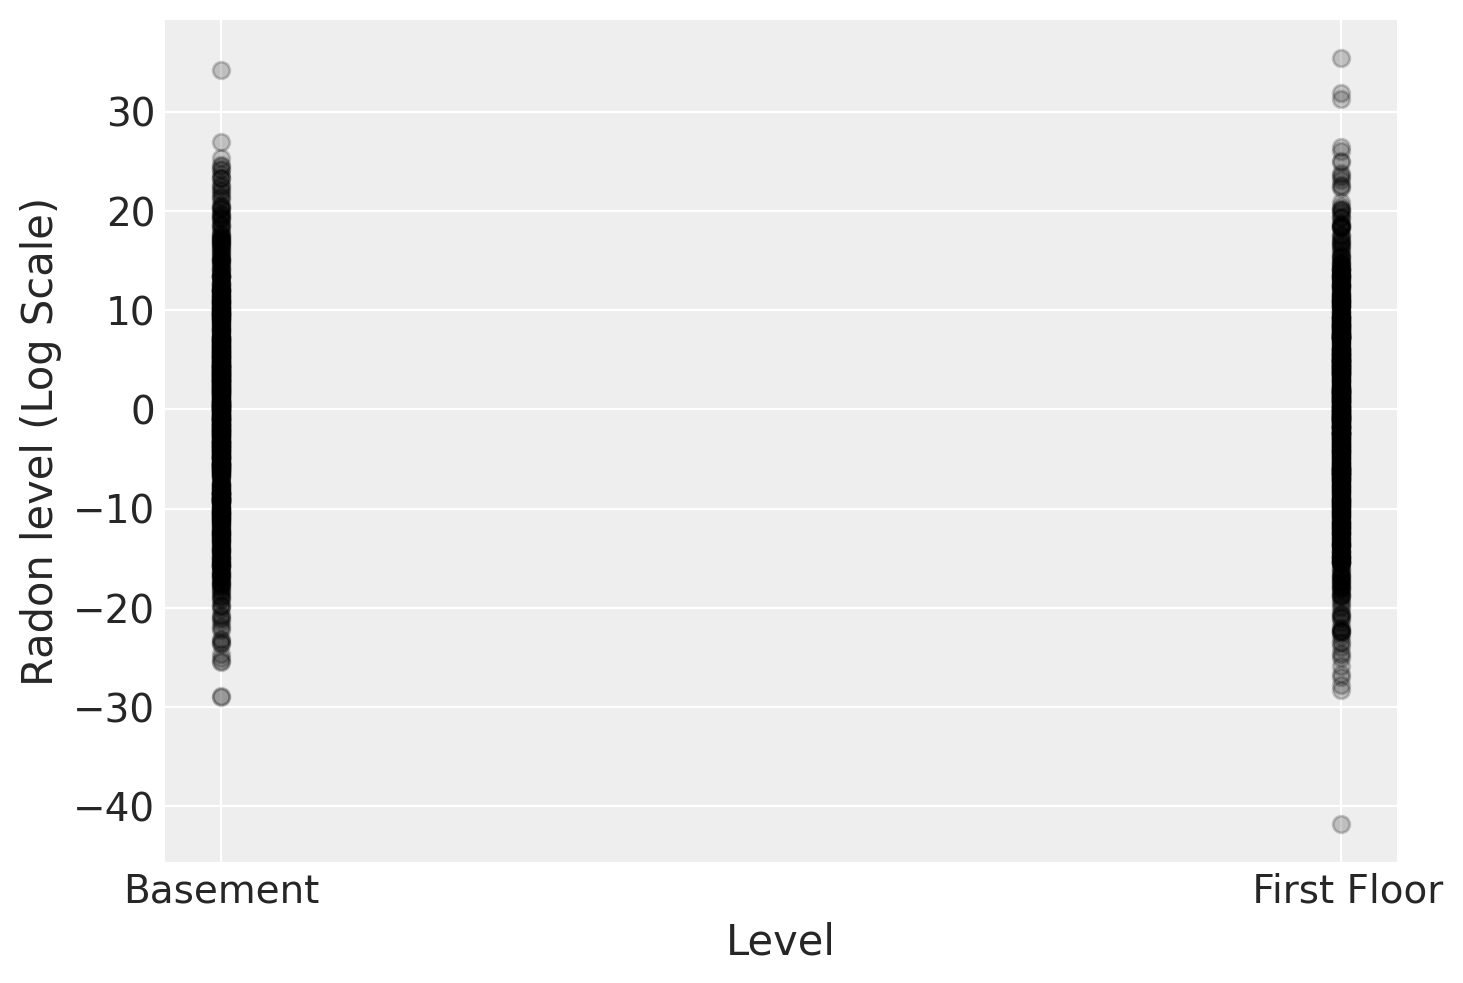

In [ ]:
_, ax = plt.subplots()
prior_checks.assign_coords(coords={"a_dim_0": ["Basement", " First Floor"]}, inplace=True)
prior_checks.prior_predictive.plot.scatter(x="a_dim_0", y="a", color="k", alpha=0.2, ax=ax)
ax.set(xlabel="Level", ylabel="Radon level (Log Scale)");

As there is no `coords` and `dims` integration to PyMC4's ModelTemplate, we need a bit extra manipulations to handle them. Here we need to assign_coords to dimensions of variable `a` to consider `Basement` and `First Floor`.

Before seeing the data, these priors seem to allow for quite a wide range of the mean log radon level. 
Let's fire up Variational Inference machinery and fit the model -

In [ ]:
pooled_advi = pm.fit(pooled_model(), num_steps=25_000)

|>>>>>>>>>>>>>>>>>>>>|

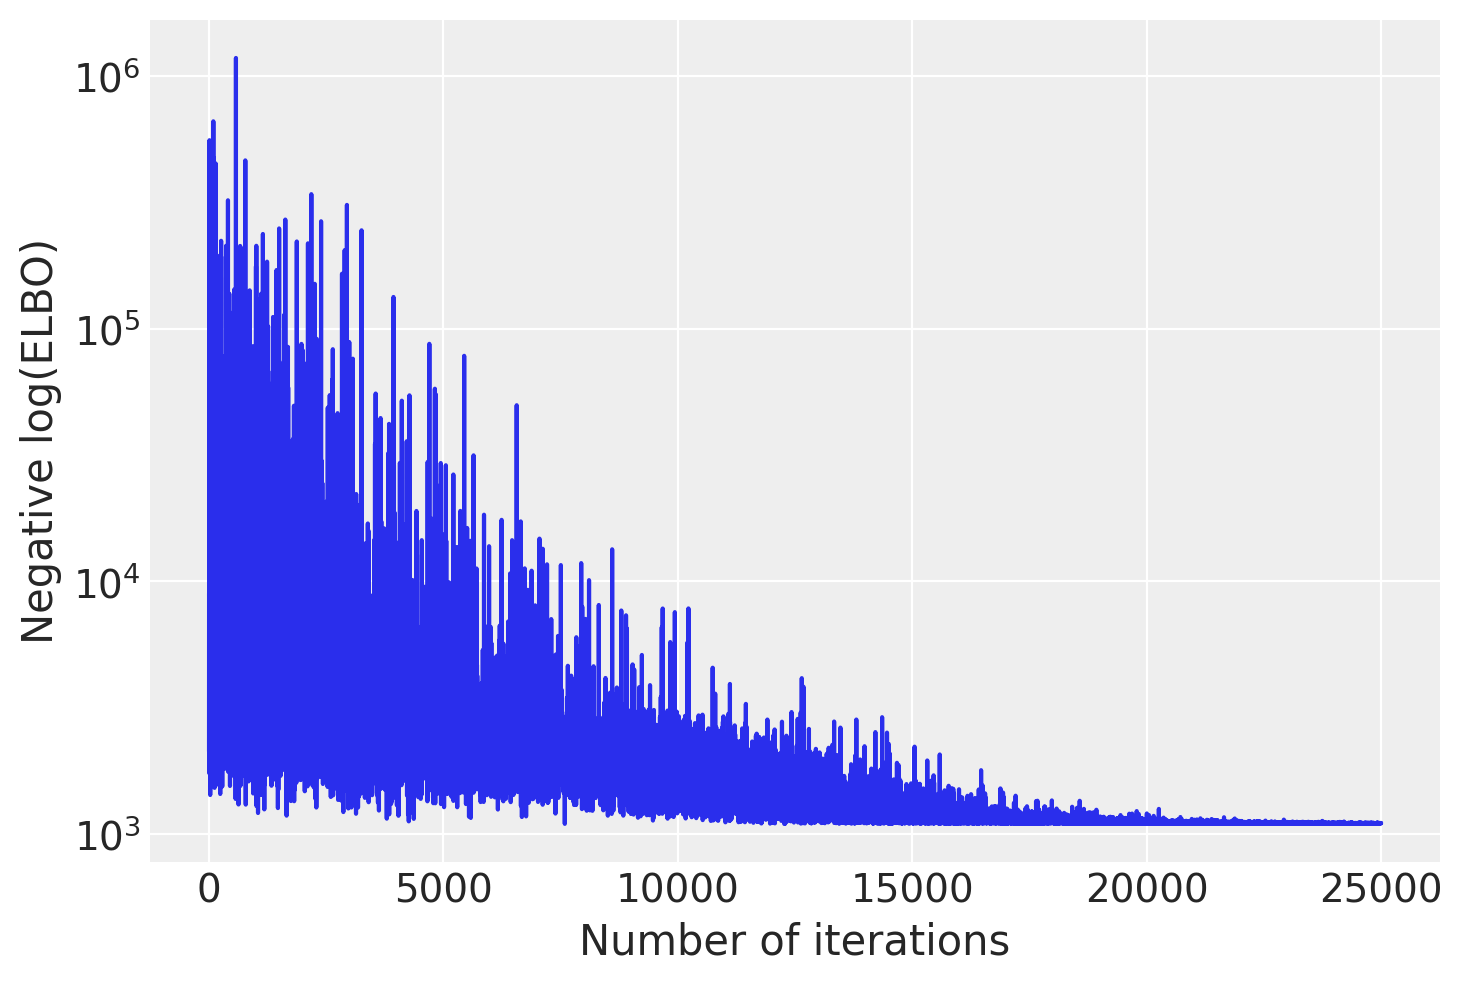

In [ ]:
def plot_elbo(loss):
    plt.plot(loss)
    plt.yscale("log")
    plt.xlabel("Number of iterations")
    plt.ylabel("Negative log(ELBO)")

plot_elbo(pooled_advi.losses)

Looks good, ELBO seems to have converged. As a sanity check, we will plot ELBO each time after fitting a new model to figure out its convergence.

Now, we'll draw samples from the posterior distribution. And then, pass these samples to `sample_posterior_predictive` to estimate the **uncertainty** at Basement and First Floor radon levels.

In [ ]:
pooled_advi_samples = pooled_advi.approximation.sample(2_000)
pooled_advi_samples

Inference data with groups:
	> posterior
	> observed_data

In [ ]:
posterior_predictive = pm.sample_posterior_predictive(pooled_model(), pooled_advi_samples)
remove_scope(posterior_predictive)
posterior_predictive

Inference data with groups:
	> posterior
	> posterior_predictive
	> observed_data

We now want to calculate the highest density interval given by the posterior predictive on Radon levels. However, we are not interested in the HDI of each observation but in the HDI of each level (either Basement or First Floor). We first group posterior_predictive samples using `coords` and then pass the specific dimensions ("chain", "draw", "obs_id") to `az.hdi`.

In [ ]:
floor = xr.DataArray(floor, dims=("obs_id"))
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = posterior_predictive.posterior_predictive["y"].groupby(floor).apply(hdi_helper)["y"]
hdi_ppc

<xarray.DataArray 'y' (group: 2, hdi: 2)>
array([[-0.12597895,  2.84736681],
       [-0.7139045 ,  2.26243448]])
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
  * group    (group) int64 0 1

In addition, ArviZ has also included the hdi_prob as an attribute of the hdi coordinate, click on its file icon to see it!

We will now add one extra coordinate to the observed_data group: the Level labels (not indices). This will allow xarray to automatically generate the correct xlabel and xticklabels so we don’t have to worry about labeling too much. In this particular case we will only do one plot, which makes the adding of a coordinate a bit of an overkill. In many cases however, we will have several plots and using this approach will automate labeling for all plots. Eventually, we will sort by Level coordinate to make sure Basement is the first value and goes at the left of the plot.

In [ ]:
posterior_predictive.rename(name_dict={"a_dim_0": "Level"}, inplace=True)
posterior_predictive.assign_coords({"Level": ["Basement", "First Floor"]}, inplace=True)
level_labels = posterior_predictive.posterior.Level[floor]
posterior_predictive.observed_data = posterior_predictive.observed_data.assign_coords(Level=level_labels).sortby("Level")

Plot the point estimates of the slope and intercept for the complete pooling model.

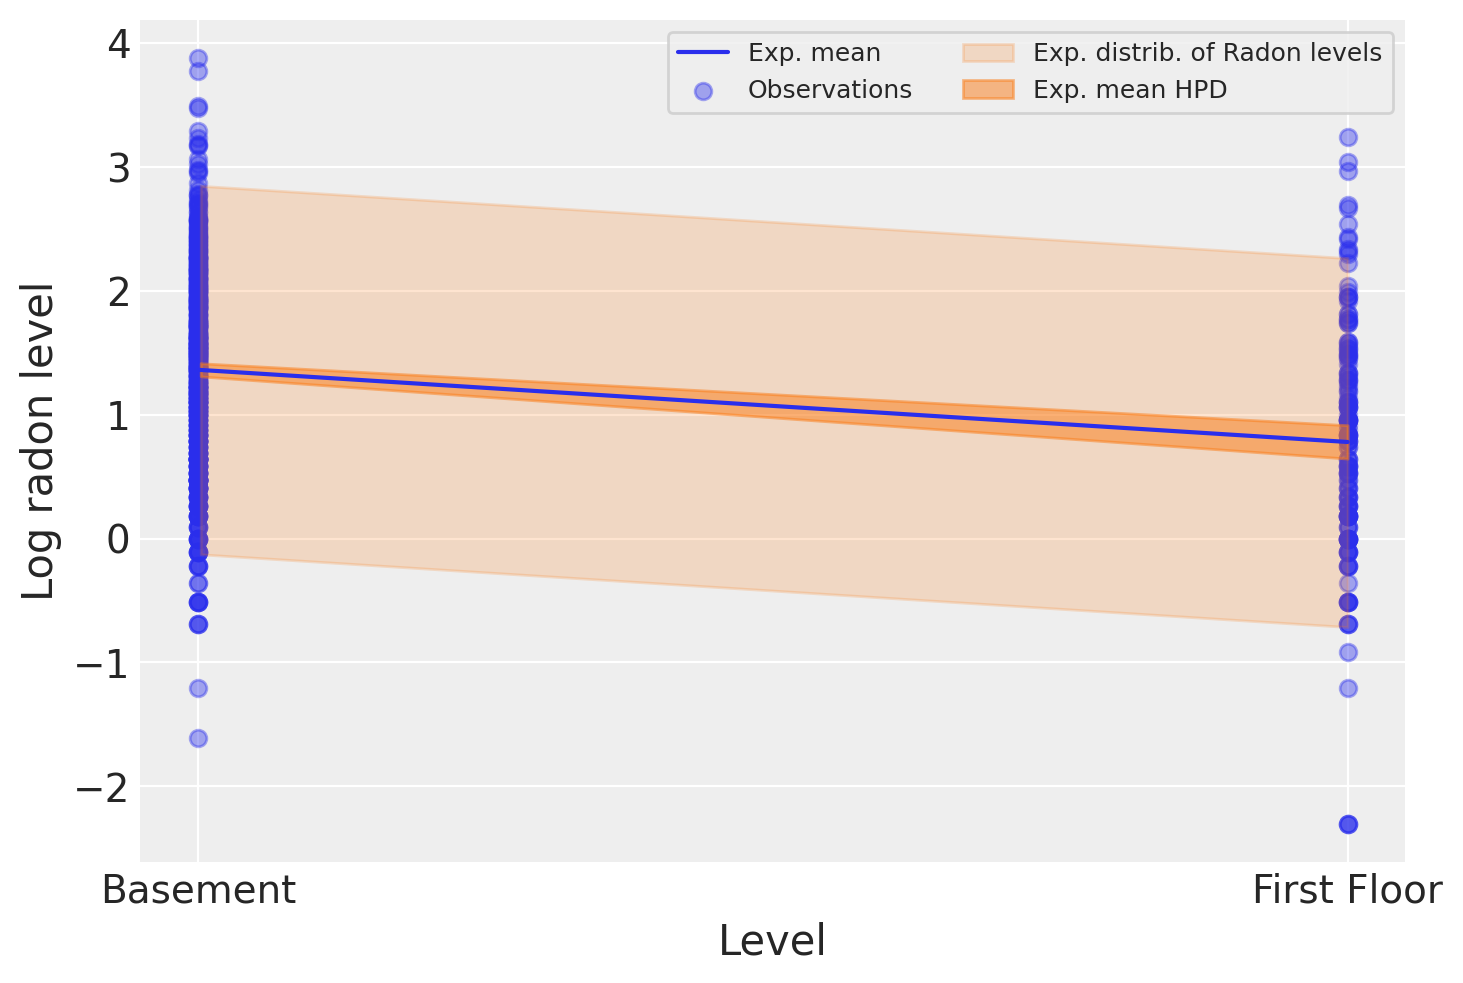

In [ ]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "First Floor"]})
posterior_predictive.posterior["a"] = posterior_predictive.posterior.a[:, :, 0] + posterior_predictive.posterior.a[:, :, 1] * xvals
pooled_means = posterior_predictive.posterior.mean(dim=("chain", "draw"))

_, ax = plt.subplots()
posterior_predictive.observed_data.plot.scatter(x="Level", y="y", label="Observations", alpha=0.4, ax=ax)

az.plot_hdi(
    [0, 1], hdi_data=hdi_ppc, fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of Radon levels"}, ax=ax
)

az.plot_hdi(
    [0, 1], posterior_predictive.posterior.a, fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}, ax=ax
)
ax.plot([0, 1], pooled_means.a, label="Exp. mean")

ax.set_ylabel("Log radon level")
ax.legend(ncol=2, fontsize=9, frameon=True);

The 94% interval of the expected value is very narrow, and even narrower for basement measurements, meaning that the model is slightly more confident about these observations. The sampling distribution of individual radon levels is much wider. We can infer that floor level does account for some of the variation in radon levels. We can see however that the model **underestimates** the dispersion in radon levels across households – lots of them lie outside the light orange prediction envelope. Also, the error rates are high representing **high bias**. So this model is a good start but we can’t stop there.

### No pooling:
Here we do not pool the estimates of the intercepts but completely pool the slope estimates assuming the variance is same within each county.
$$
y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i
$$
where $j$ = 1, ..., 85 representing each county.

In [ ]:
@pm.model
def unpooled_model():
    a_county = yield pm.Normal('a_county', loc=0., scale=10., batch_stack=counties)
    beta = yield pm.Normal('beta', loc=0, scale=10.)
    loc = tf.gather(a_county, county_idx) + beta*floor
    scale = yield pm.Exponential("sigma", rate=1.)

    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)

|>>>>>>>>>>>>>>>>>>>>|

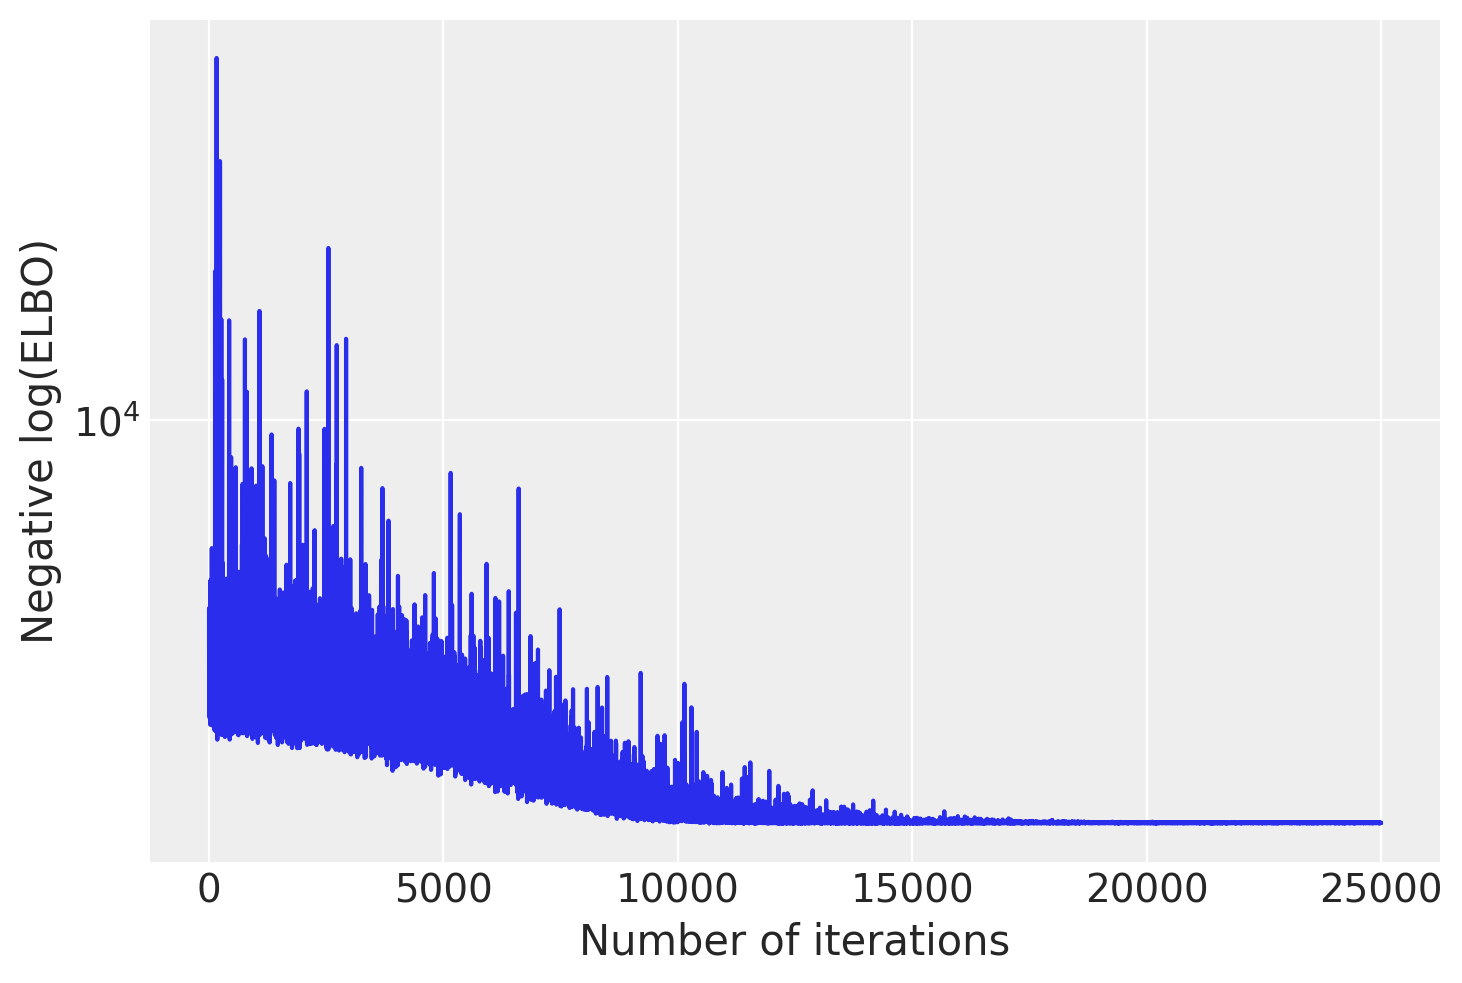

In [ ]:
unpooled_advi = pm.fit(unpooled_model(), num_steps=25_000)
plot_elbo(unpooled_advi.losses)

In [ ]:
unpooled_advi_samples = unpooled_advi.approximation.sample(2_000)
remove_scope(unpooled_advi_samples)
unpooled_advi_samples

Inference data with groups:
	> posterior
	> observed_data

Let’s plot each county's expected values with 94% confidence interval.

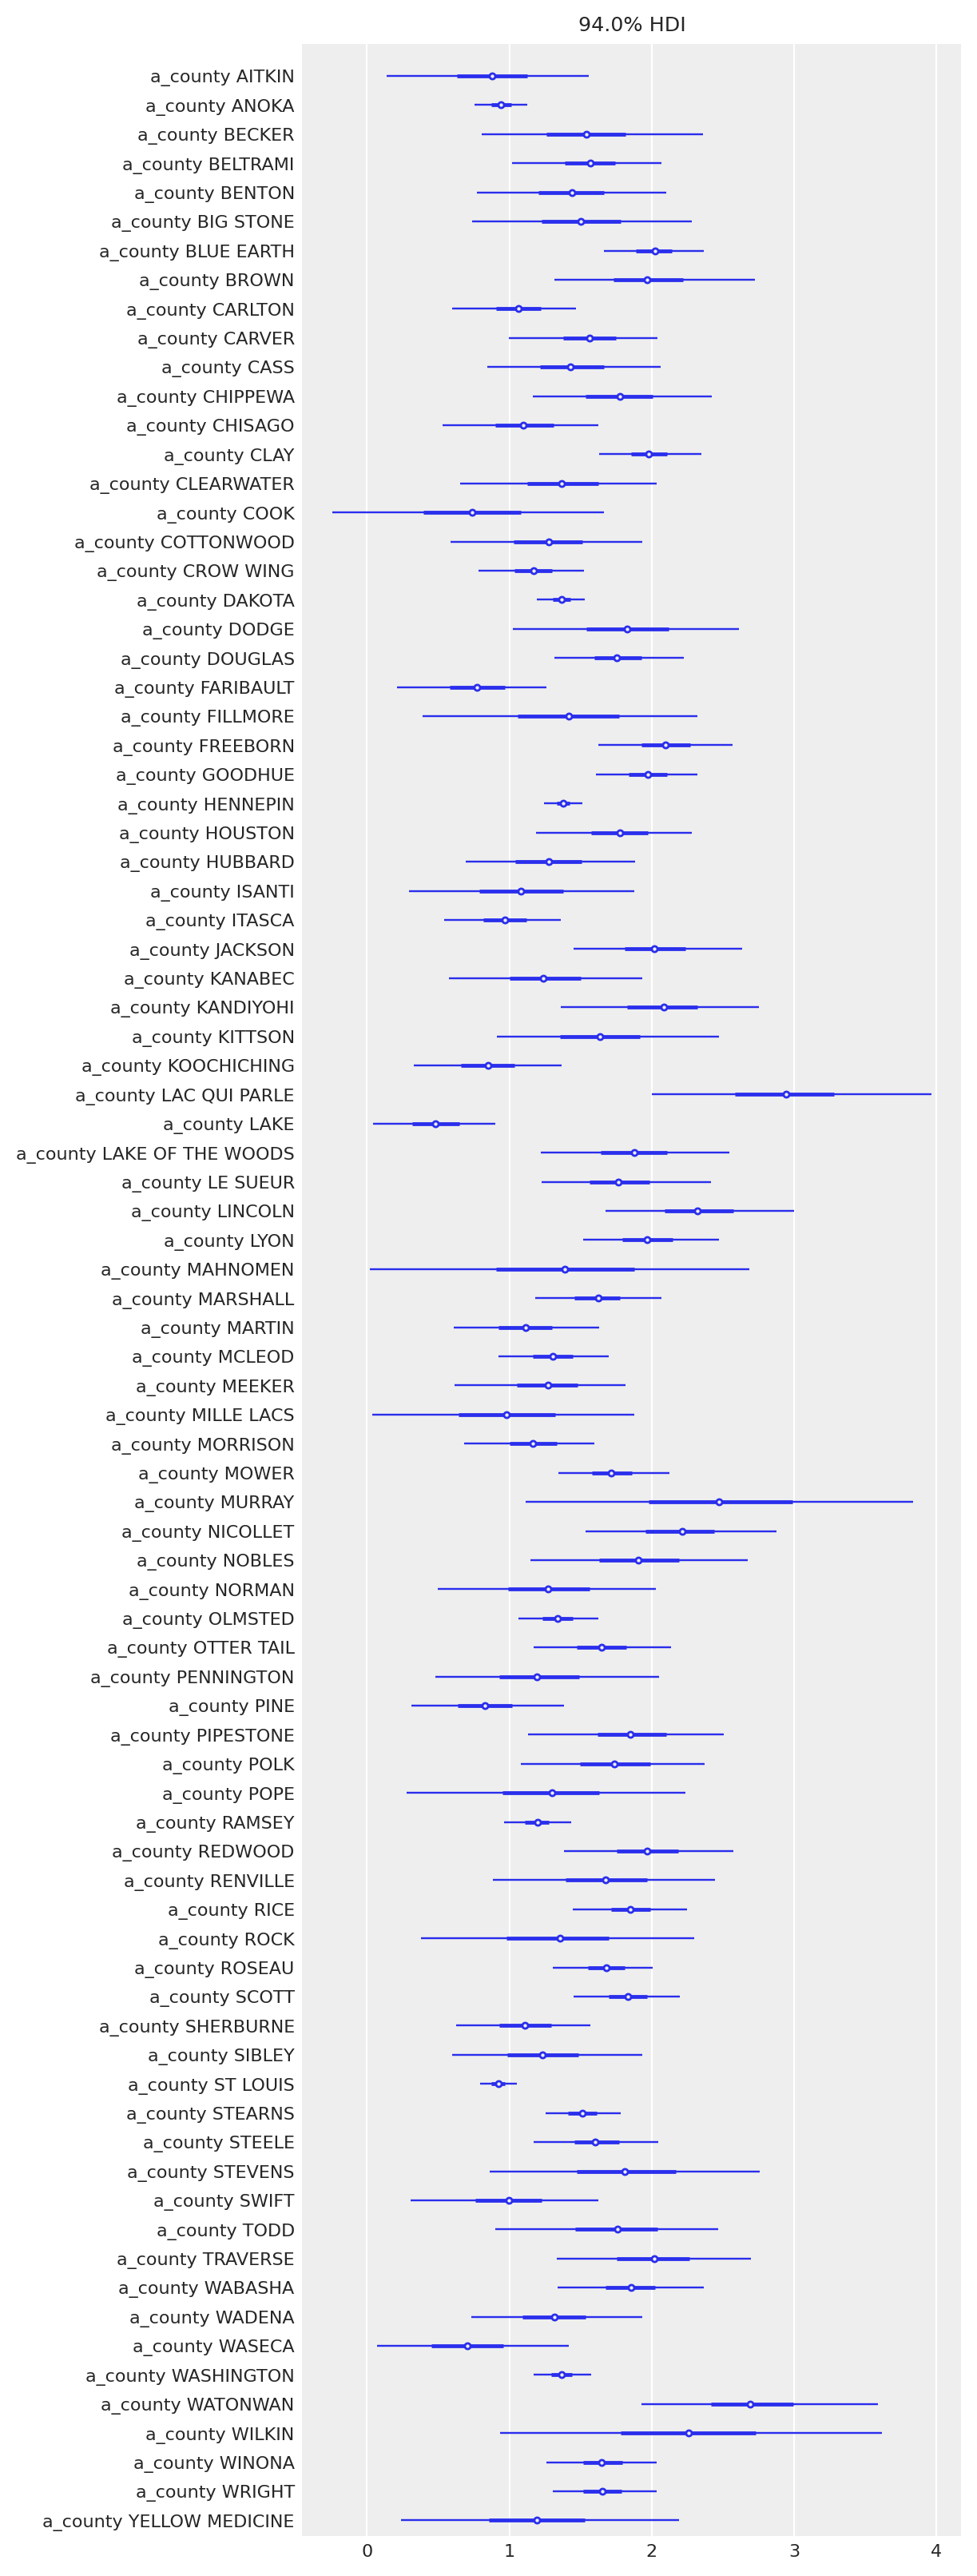

In [ ]:
unpooled_advi_samples.assign_coords(coords={"a_county_dim_0": mn_counties}, inplace=True)
az.plot_forest(
    unpooled_advi_samples, var_names="a_county", figsize=(6, 16), combined=True, textsize=8
);

Looking at the counties all together, the `unpooling` analysis **overfits** the data within each county. Also giving a view that individual counties look more different than they actually are.

Since we are modelling data within each county, we can plot the ordered mean estimates to identify counties with **high** radon levels.

In [ ]:
unpooled_means = unpooled_advi_samples.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_advi_samples)

We will now take advantage of label based indexing for Datasets with the sel method and of automagical sorting capabilities. We first sort using the values of a specific 1D variable `a`. Then, thanks to unpooled_means and unpooled_hdi both having the `a_county_dim_0` (representing each county) dimension, we can pass a 1D DataArray to sort the second dataset too.

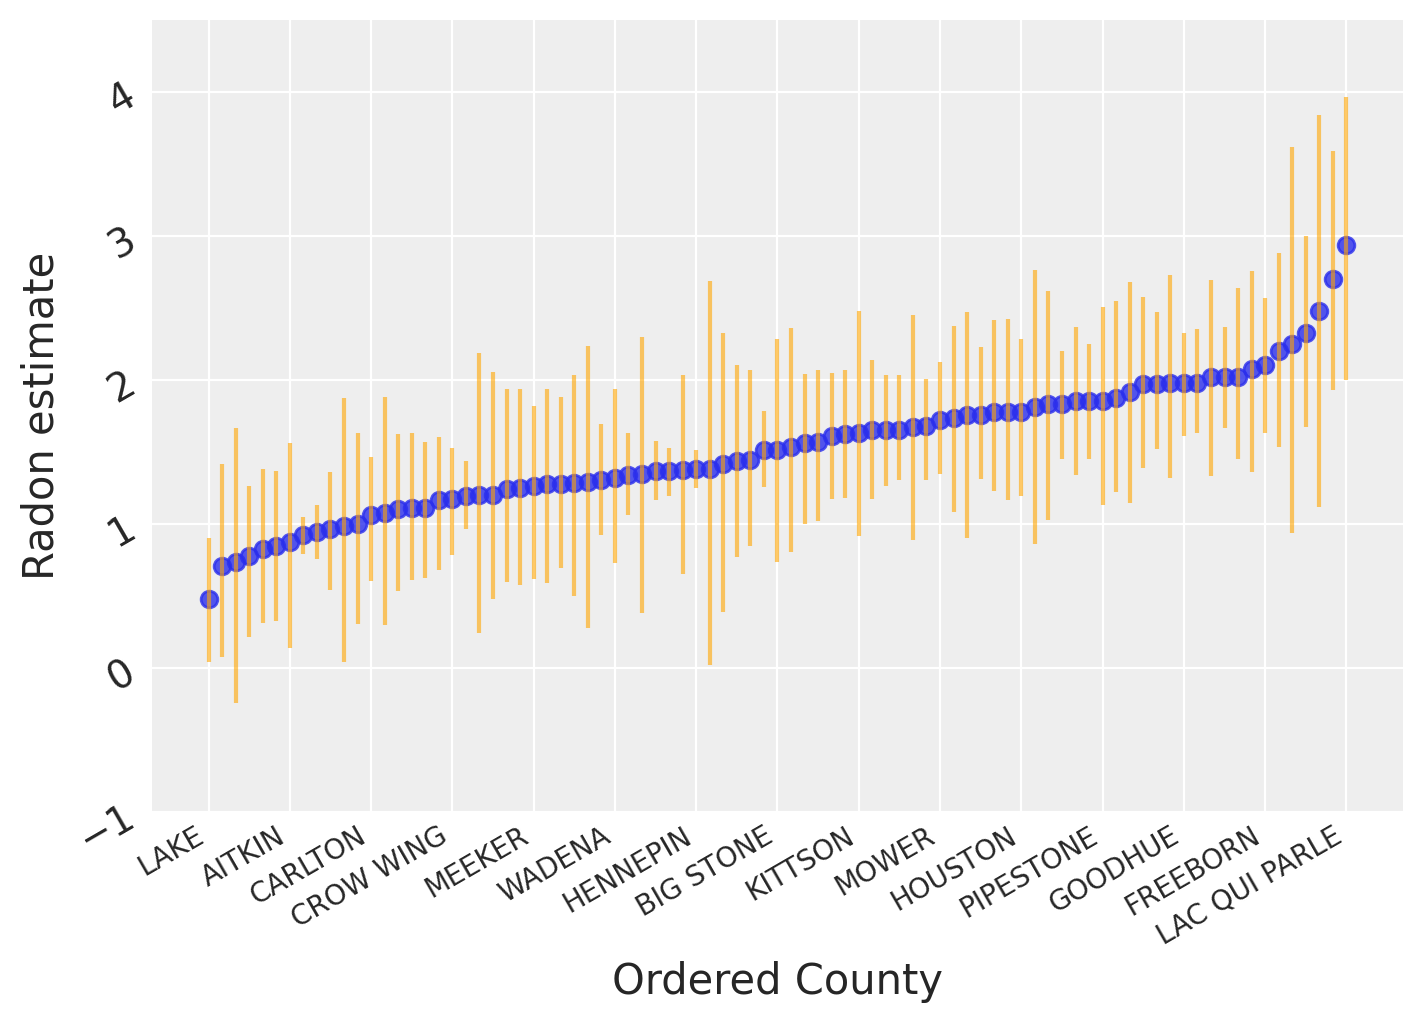

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
xticks = np.arange(0, 86, 6)
fontdict = {"horizontalalignment": "right", "fontsize": 10}

unpooled_means_iter = unpooled_means.sortby("a_county")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter["a_county"])
unpooled_means_iter.plot.scatter(x=f"a_county_dim_0", y="a_county", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(counties),
    unpooled_hdi_iter["a_county"].sel(hdi="lower"),
    unpooled_hdi_iter["a_county"].sel(hdi="higher"),
    color="orange", alpha=0.6
)
ax.set(
    ylabel="Radon estimate",
    xlabel="Ordered County",
    ylim=(-1, 4.5),
    xticks=xticks
)
ax.set_xticklabels(unpooled_means_iter[f"a_county_dim_0"].values[xticks], fontdict=fontdict)
ax.tick_params(rotation=30)

Here are some visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

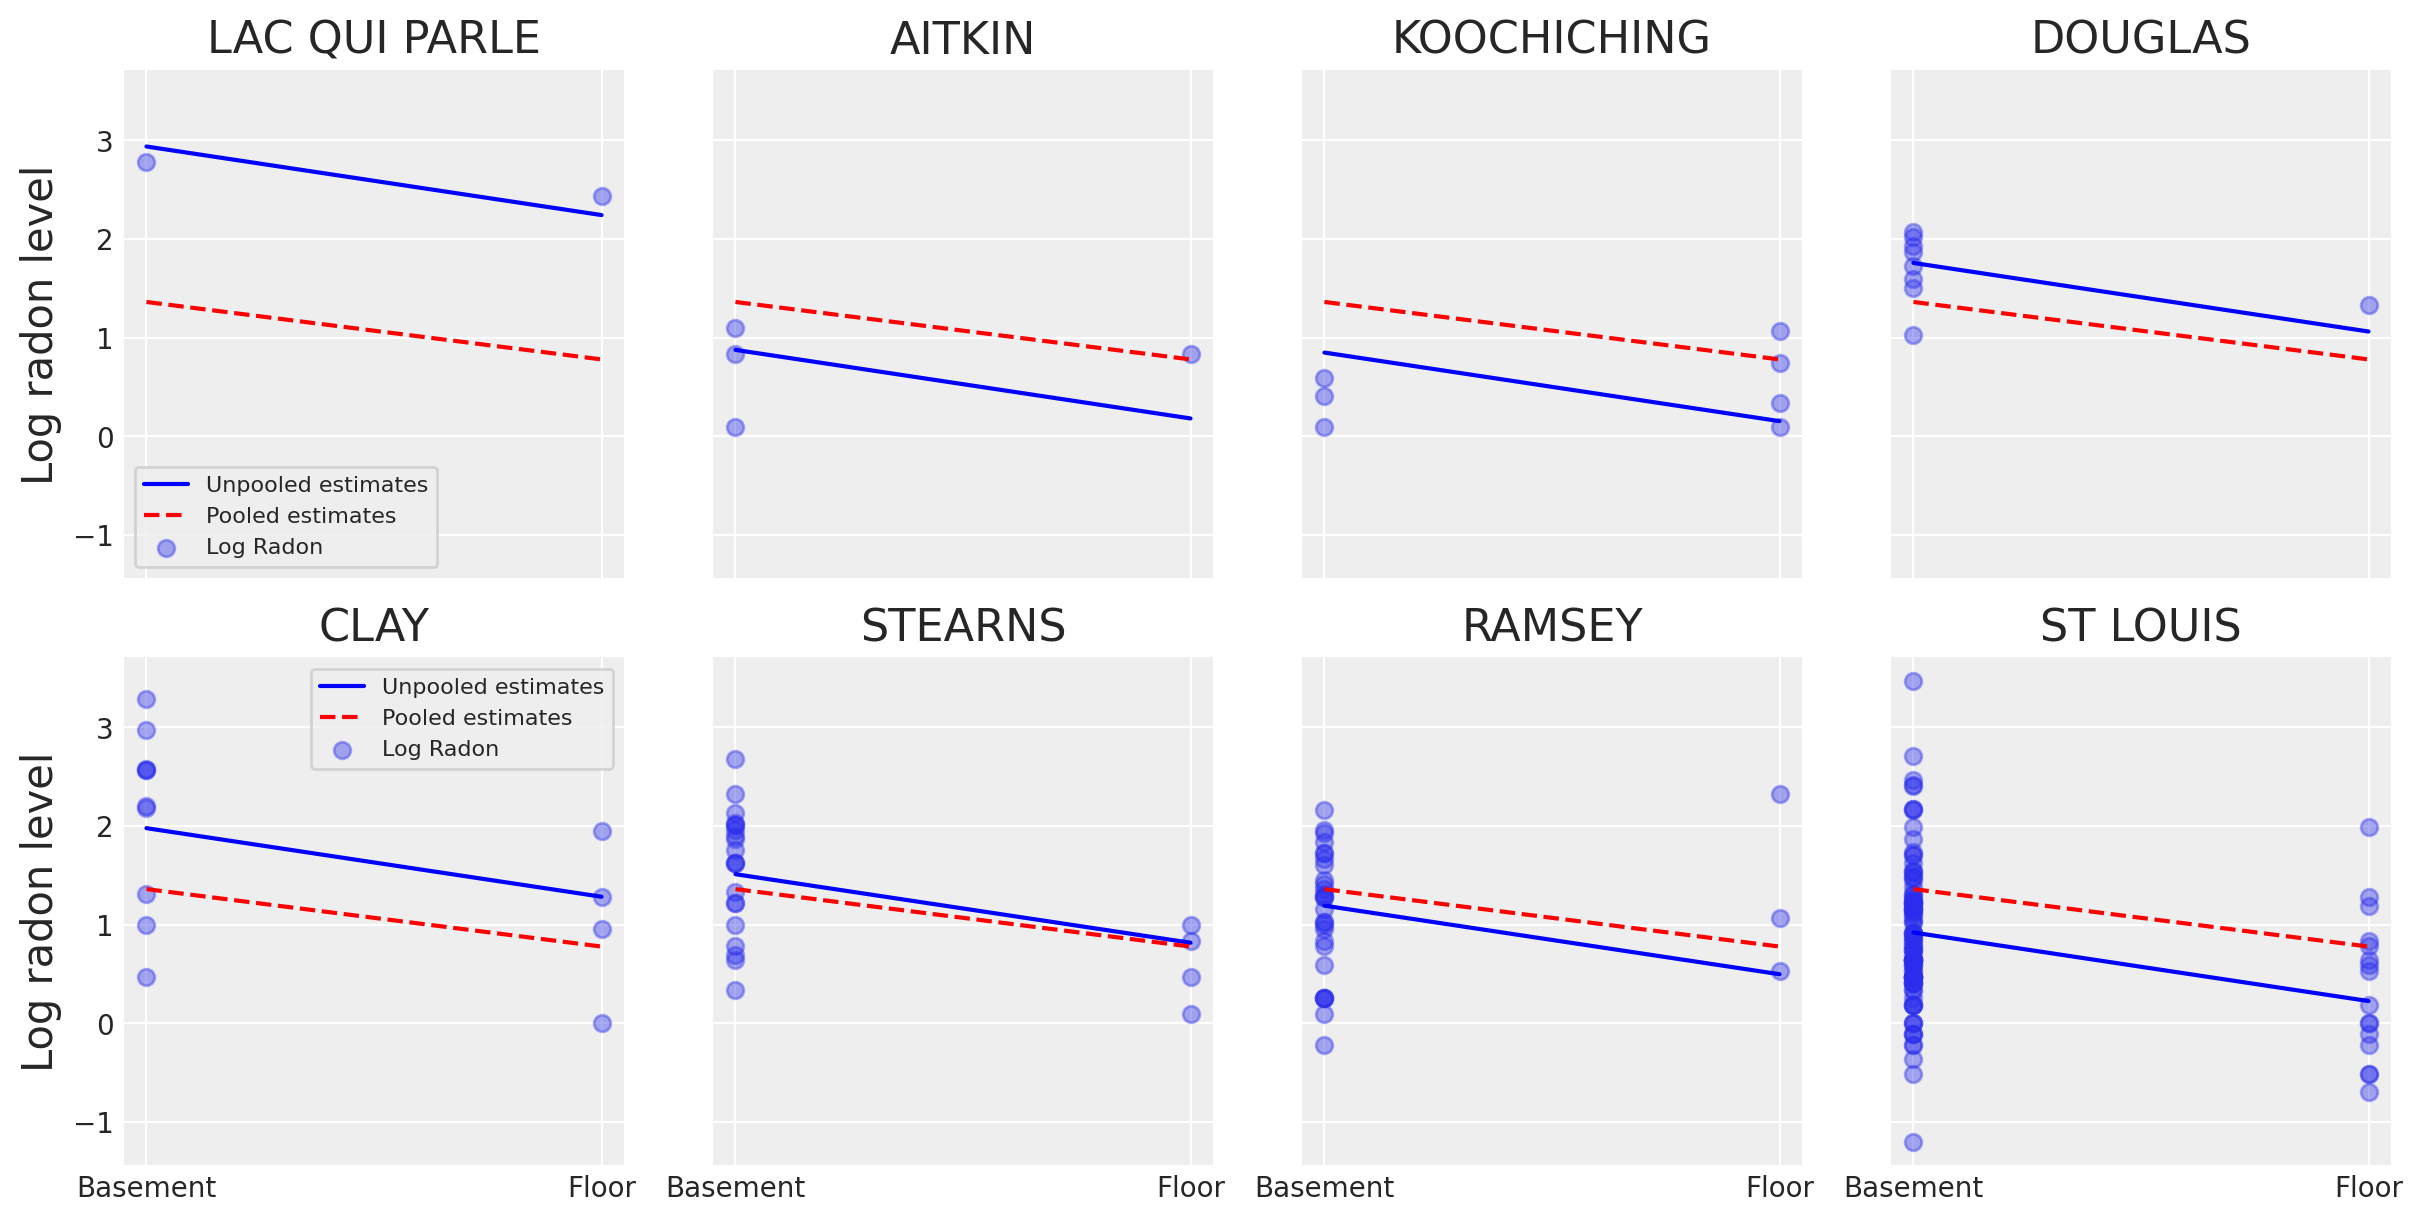

In [ ]:
SAMPLE_COUNTIES = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

unpooled_advi_samples.observed_data = unpooled_advi_samples.observed_data.assign_coords({
    "County": ("obs_id", mn_counties[county_idx]),
    "Level": ("obs_id", np.array(["Basement", "Floor"])[floor.values.astype(np.int32)])
})


fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
xspace = np.linspace(0, 1, 100)
for ax, c in zip(axes.ravel(), SAMPLE_COUNTIES):
    sample_county_mask = unpooled_advi_samples.observed_data.County.isin([c])

    # plot obs:
    unpooled_advi_samples.observed_data.where(
        sample_county_mask, drop=True
    ).sortby("Level").plot.scatter(x="Level", y="y", ax=ax, alpha=.4, label="Log Radon")

    # plot both models:
    ax.plot([0, 1], unpooled_means.a_county.sel(a_county_dim_0=c) + unpooled_means.beta*xvals, "b", label="Unpooled estimates")
    ax.plot([0, 1], pooled_means.a, "r--", label="Pooled estimates")

    ax.set_title(c); ax.set_xlabel(""); ax.set_ylabel("")
    ax.tick_params(labelsize=10)

axes[0,0].set_ylabel("Log radon level"); axes[1,0].set_ylabel("Log radon level")
axes[0,0].legend(fontsize=8, frameon=True); axes[1,0].legend(fontsize=8, frameon=True);

Notice the slopes $\beta$ differ slightly. The county `LAC QUI PARLE` has the **highest** average radon level from 85 counties as it is evident from the previous plot. But these estimates are calculated with just two observations. And there is a big shift in its intercept from complete pooling to no pooling. This is a classic issue with no-pooling models: when you estimate clusters independently from each other, can you trust estimates from small-sample-size counties?

Neither of these models are satisfactory:

* If we are trying to identify high-radon counties, pooling is not useful as it ignores any **variation** in average radon levels between counties.
* We do not trust extreme unpooled estimates produced by models using few observations. This leads to maximal overfitting: only the within-county variations are taken into account and the overall population is not estimated.

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance) -- we assume that counties are all the same:

![pooled](images/pooled_model.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that counties have no similarity whatsoever:

![unpooled](images/unpooled_model.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](images/partial_pooled_model.png)

We can use PyMC to easily specify multilevel models, and fit them using Variational Inference Approximations.

#### Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$
where $n_j$ is the number of houses for county $j$, $\sigma_y^{2}$ is within county variance, and $\sigma_a^{2}$ is the variance among the average log radon levels of the different counties.

We expect the following when using partial pooling:
* Estimates for counties with smaller sample sizes will shrink towards the state-wide average.
* Estimates for counties with larger sample sizes will be closer to the unpooled county estimates and will influence the the state-wide average.

In [ ]:
@pm.model
def partial_pooling():
    # Priors
    mu_a = yield pm.Normal('mu_a', loc=0., scale=10.)
    sigma_a = yield pm.HalfCauchy('sigma_a', scale=1.)

    # Intercepts
    a_county = yield pm.Normal('a_county', loc=mu_a, scale=sigma_a, batch_stack=counties)

    loc = tf.gather(a_county, county_idx)
    scale = yield pm.Exponential("sigma", rate=1.)

    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)

|>>>>>>>>>>>>>>>>>>>>|

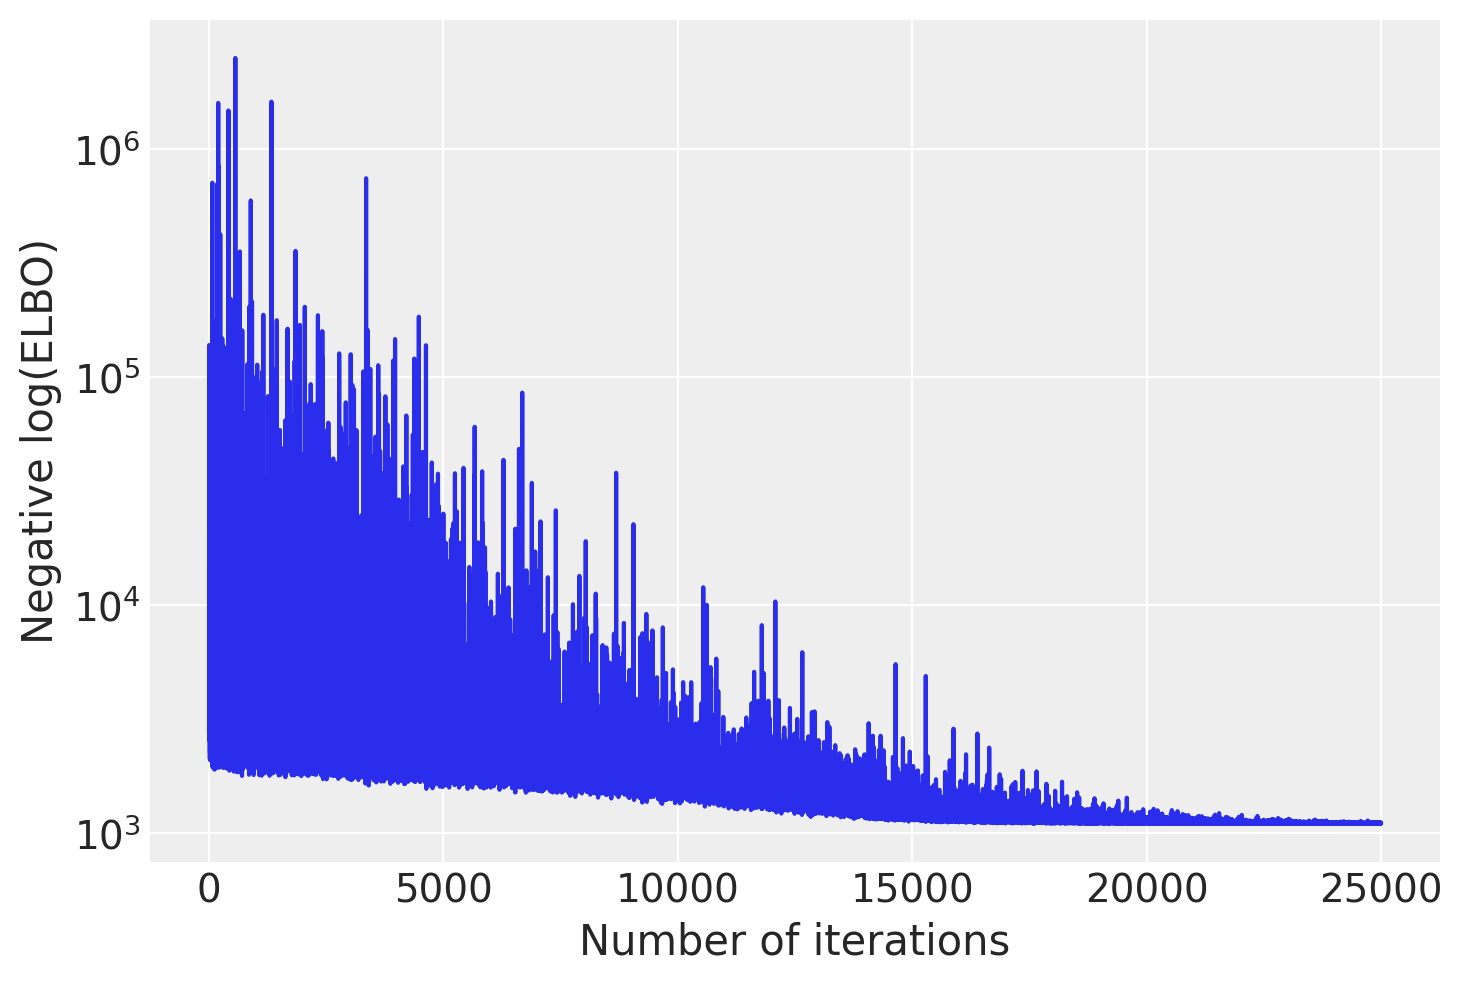

In [ ]:
partial_pooling_advi = pm.fit(partial_pooling(), num_steps=25_000)
plot_elbo(partial_pooling_advi.losses)

In [ ]:
partial_pooling_samples = partial_pooling_advi.approximation.sample(2_000)
remove_scope(partial_pooling_samples)
partial_pooling_samples

Inference data with groups:
	> posterior
	> observed_data

To compare partial-pooling and no-pooling estimates, let’s run the unpooled model without the floor predictor:

In [ ]:
@pm.model
def unpooled_without_floor():
    a_county = yield pm.Normal('a_county', loc=0., scale=10., batch_stack=counties)

    loc = tf.gather(a_county, county_idx)
    scale = yield pm.Exponential("sigma", rate=1.)

    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)

|>>>>>>>>>>>>>>>>>>>>|

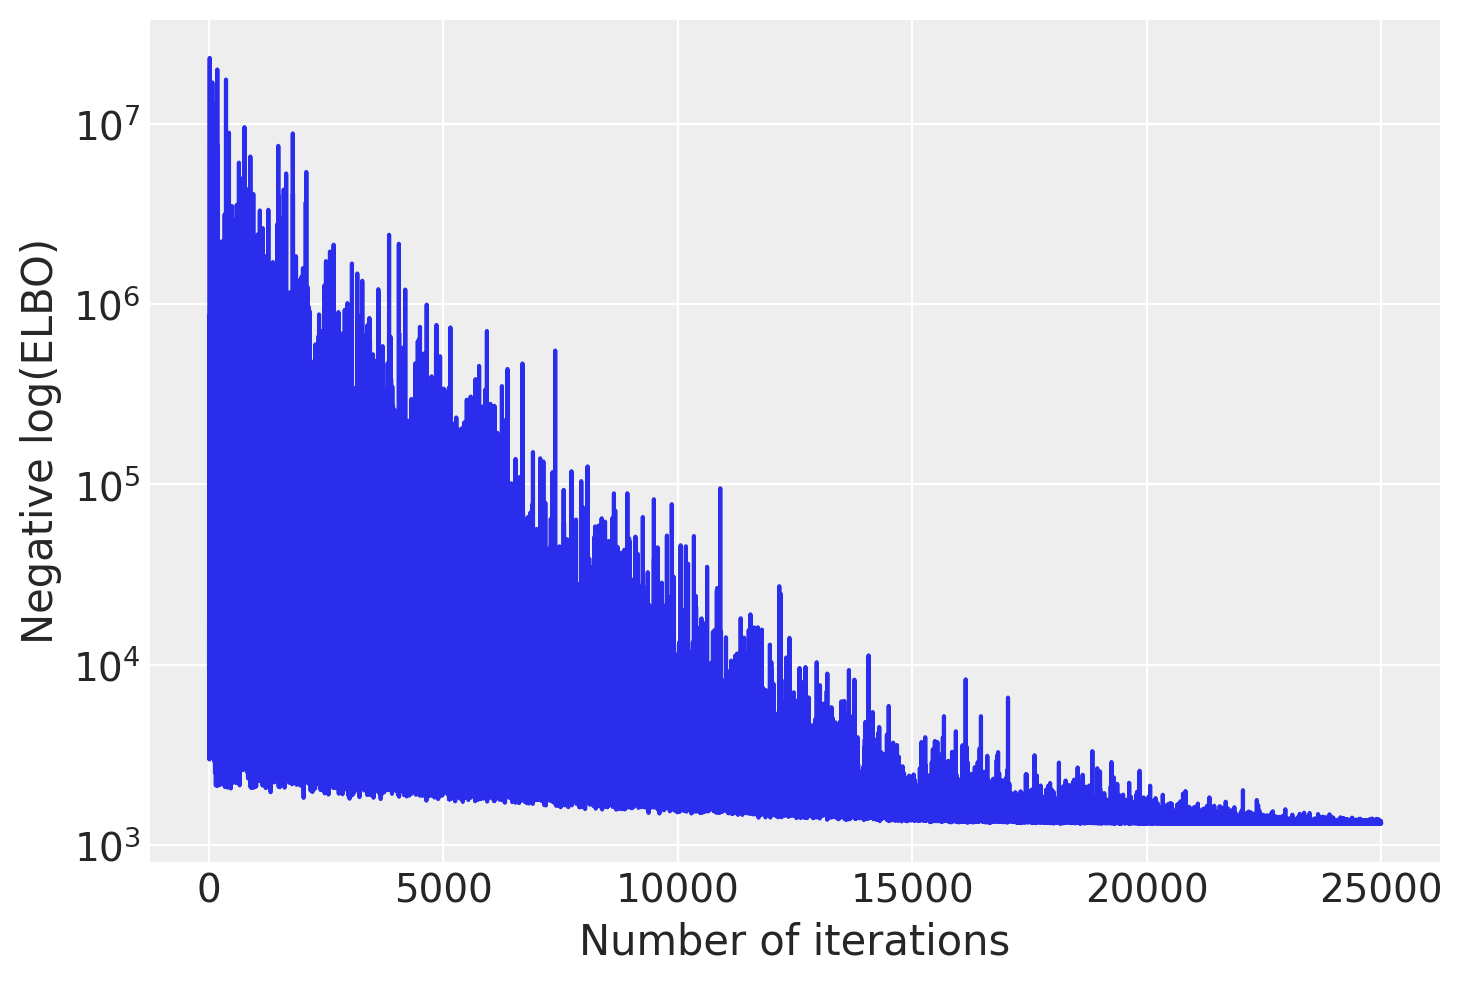

In [ ]:
unpooled_without_floor_advi = pm.fit(unpooled_without_floor(), num_steps=25_000)
plot_elbo(unpooled_without_floor_advi.losses)

In [ ]:
unpooled_without_floor_samples = unpooled_without_floor_advi.approximation.sample(2_000)
remove_scope(unpooled_without_floor_samples)
unpooled_without_floor_samples

Inference data with groups:
	> posterior
	> observed_data

Now let’s compare both models’ estimates for all 85 counties. We’ll plot the estimates against each county’s sample size, to let you see more clearly what hierarchical models bring to the table:

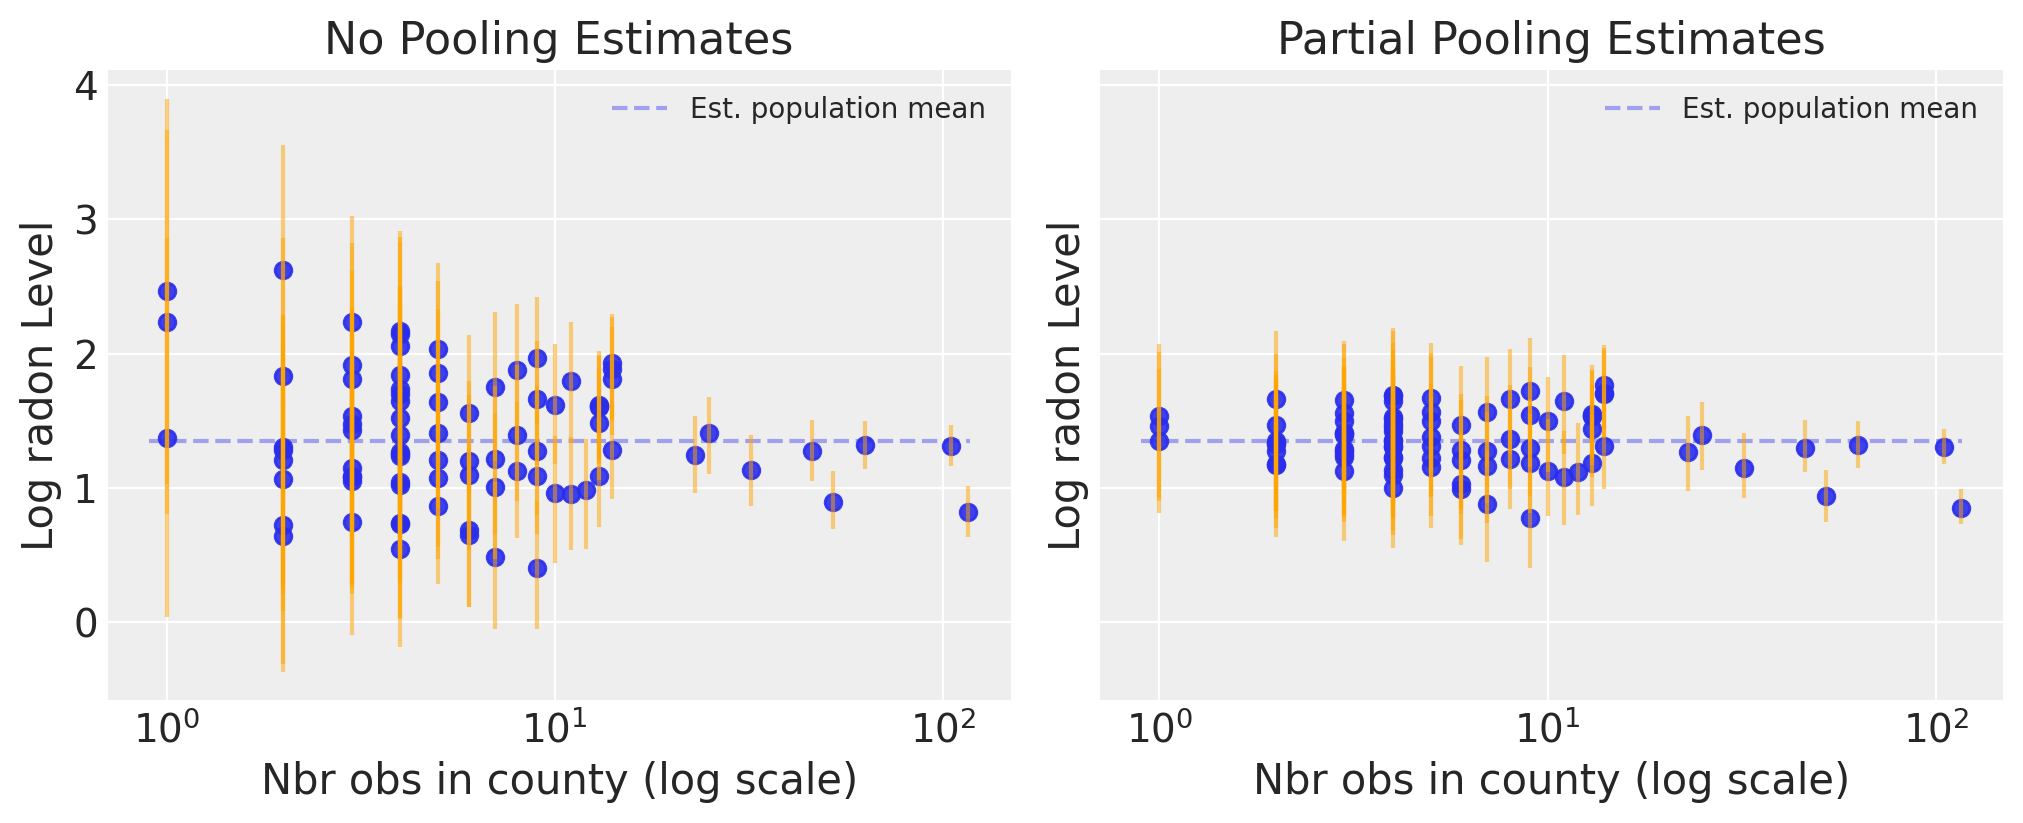

In [ ]:
N_county = data.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, idata, func_name, level in zip(
    axes,
    (unpooled_without_floor_samples, partial_pooling_samples),
    (unpooled_without_floor().name, partial_pooling().name),
    ("no pooling", "partial pooling"),
):
    # add variable with x values to xarray dataset
    idata.posterior = idata.posterior.assign_coords({"N_county": ("a_county_dim_0", N_county)})
    # plot means
    idata.posterior.mean(dim=("chain", "draw")).plot.scatter(x="N_county", y="a_county", ax=ax, alpha=0.9);
    ax.hlines(
        partial_pooling_samples.posterior.a_county.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(idata).a_county
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon Level",
    )
    ax.legend(fontsize=10)

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former is both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size counties are informed by the population parameters – hence **more precise** estimates. Moreover, the smaller the sample size, the more regression towards the **overall mean** (the dashed gray line) – hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in counties where data is sparse.

Now let’s try to integrate the floor predictor - 

#### Varying intercept model

As above, this model allows intercepts to vary across county, according to a random effect. We just add a fixed slope for the predictor (i.e all counties will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the no-pooling model, we set a separate intercept for each county, but rather than fitting separate regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data. Here is what that looks in code:

In [ ]:
@pm.model
def varying_intercept():
    mu_a = yield pm.Normal('mu_a', loc=0., scale=1e5)
    sigma_a = yield pm.HalfCauchy('sigma_a', scale=5.)

    a_county = yield pm.Normal('a_county', loc=mu_a, scale=sigma_a, batch_stack=counties)
    b = yield pm.Normal('b', loc=0., scale=10.)

    loc = tf.gather(a_county, county_idx) + b*floor
    scale = yield pm.Exponential("sigma", rate=1.)

    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)

|>>>>>>>>>>>>>>>>>>>>|

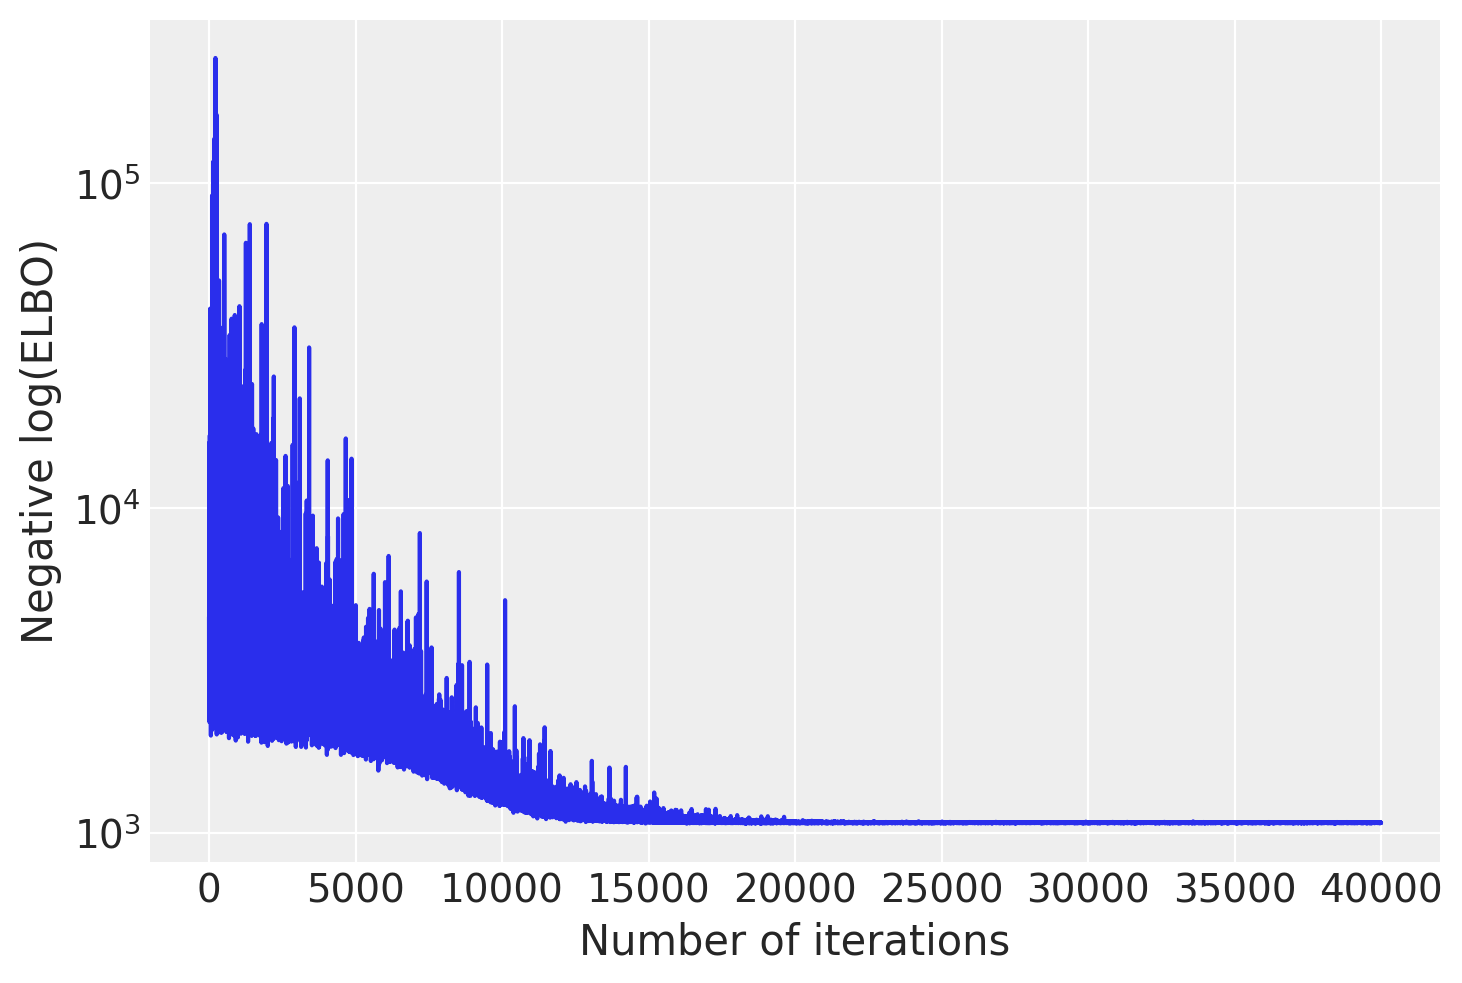

In [ ]:
varying_intercept_advi = pm.fit(varying_intercept(), num_steps=40_000)
plot_elbo(varying_intercept_advi.losses)

In [ ]:
varying_intercept_samples = varying_intercept_advi.approximation.sample(2_000)
remove_scope(varying_intercept_samples)
varying_intercept_samples

Inference data with groups:
	> posterior
	> observed_data

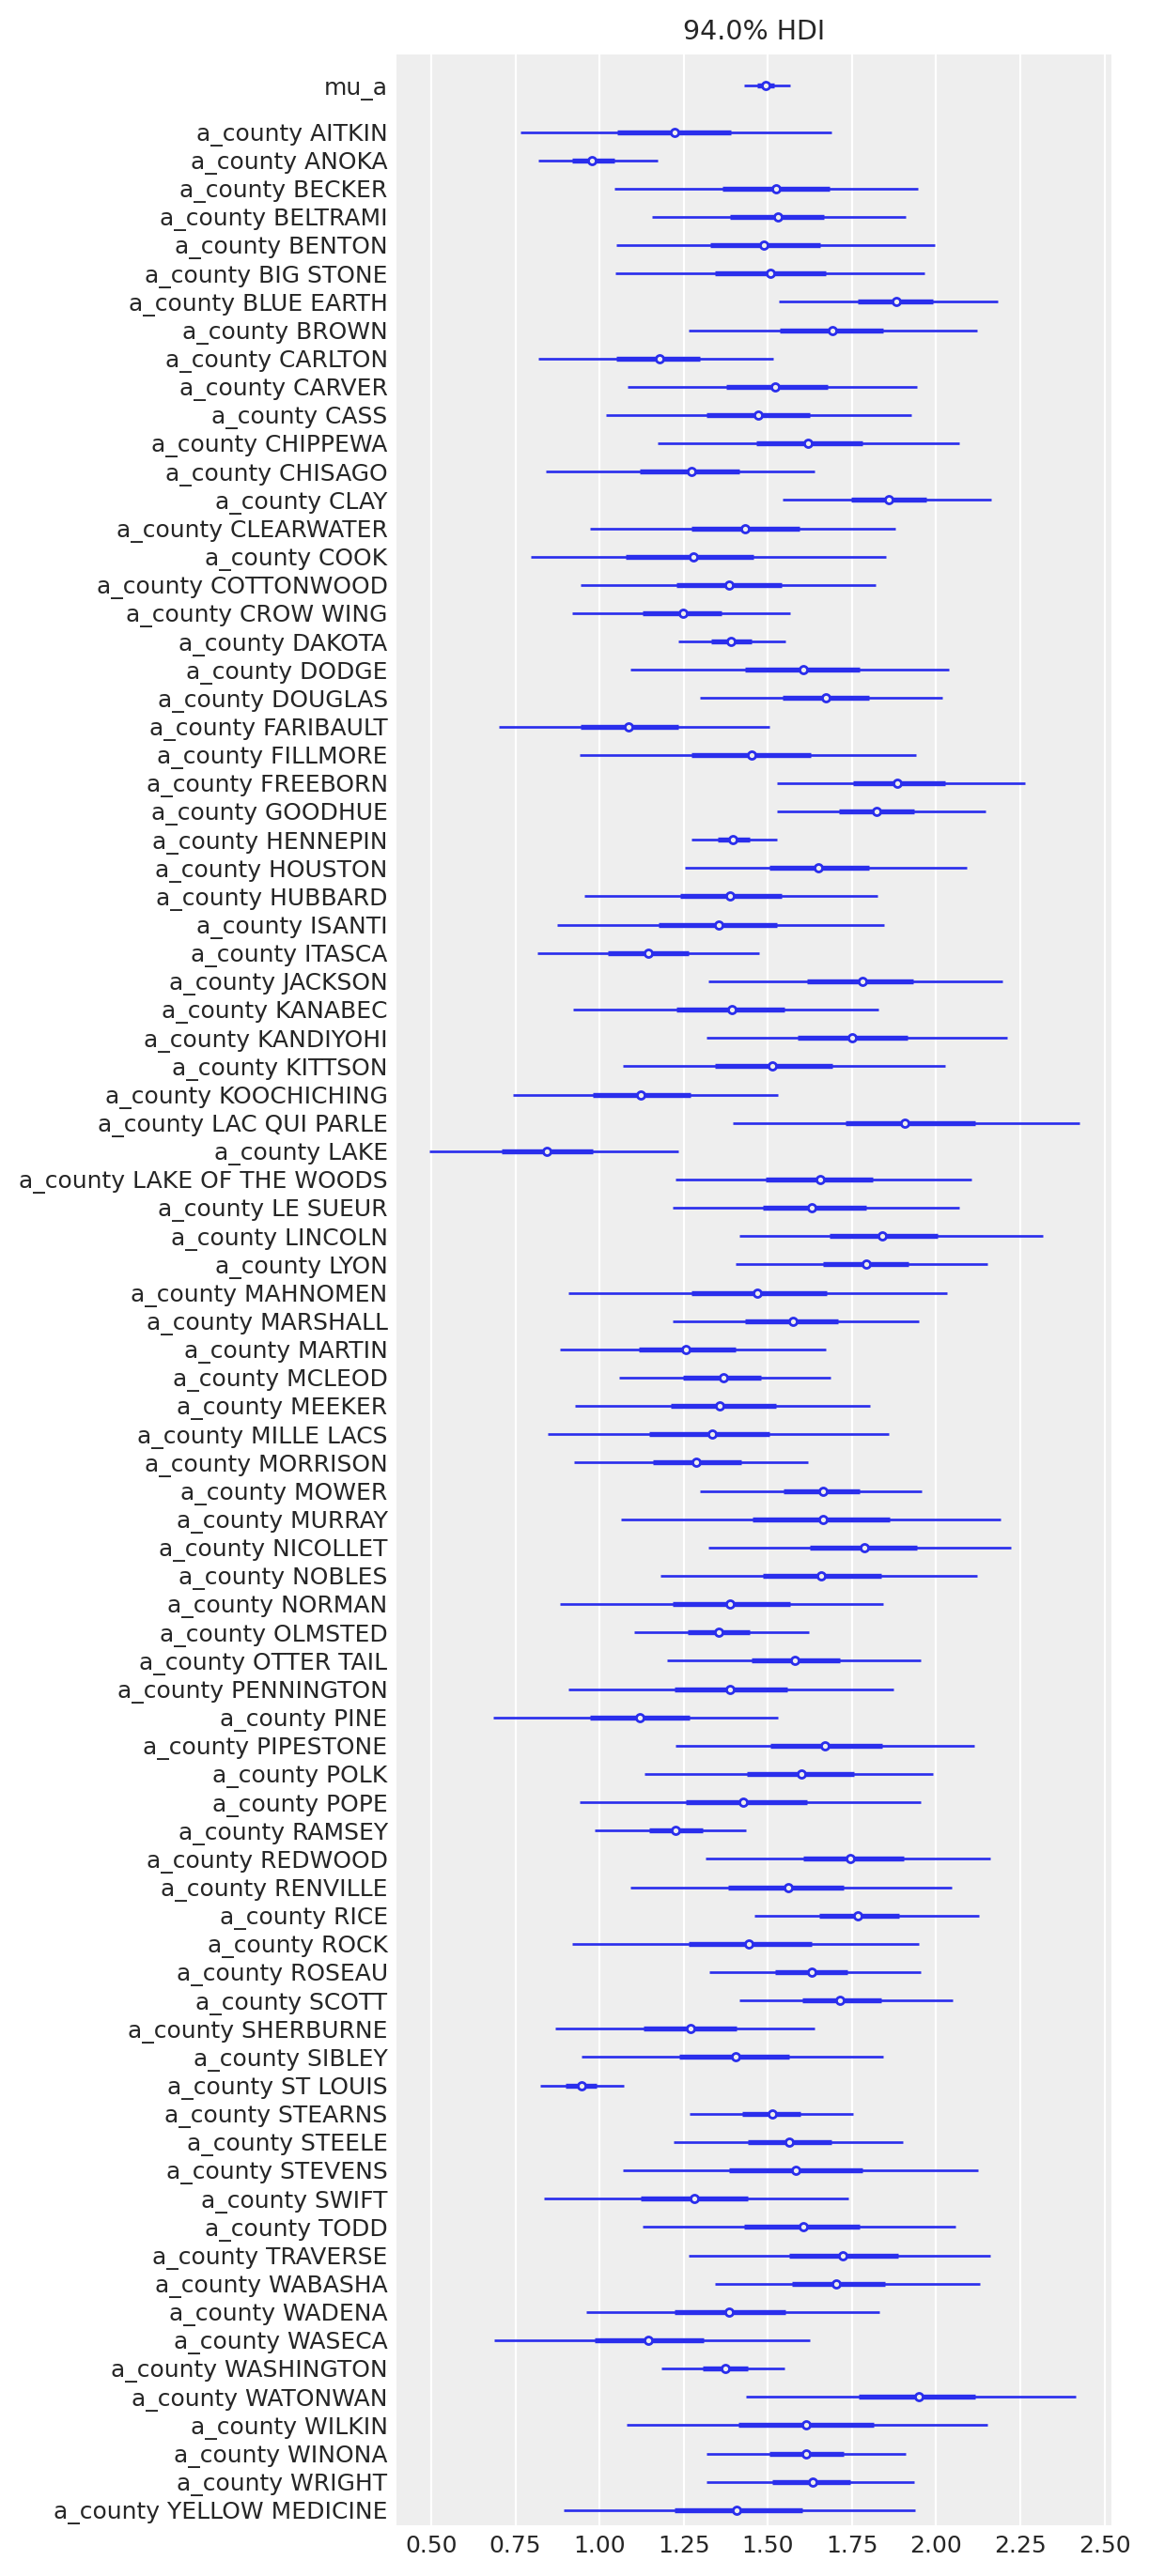

In [ ]:
varying_intercept_samples.assign_coords(**{"a_county_dim_0": mn_counties}, inplace=True)
az.plot_forest(varying_intercept_samples, var_names=["mu_a", "a_county"], combined=True, textsize=9
);

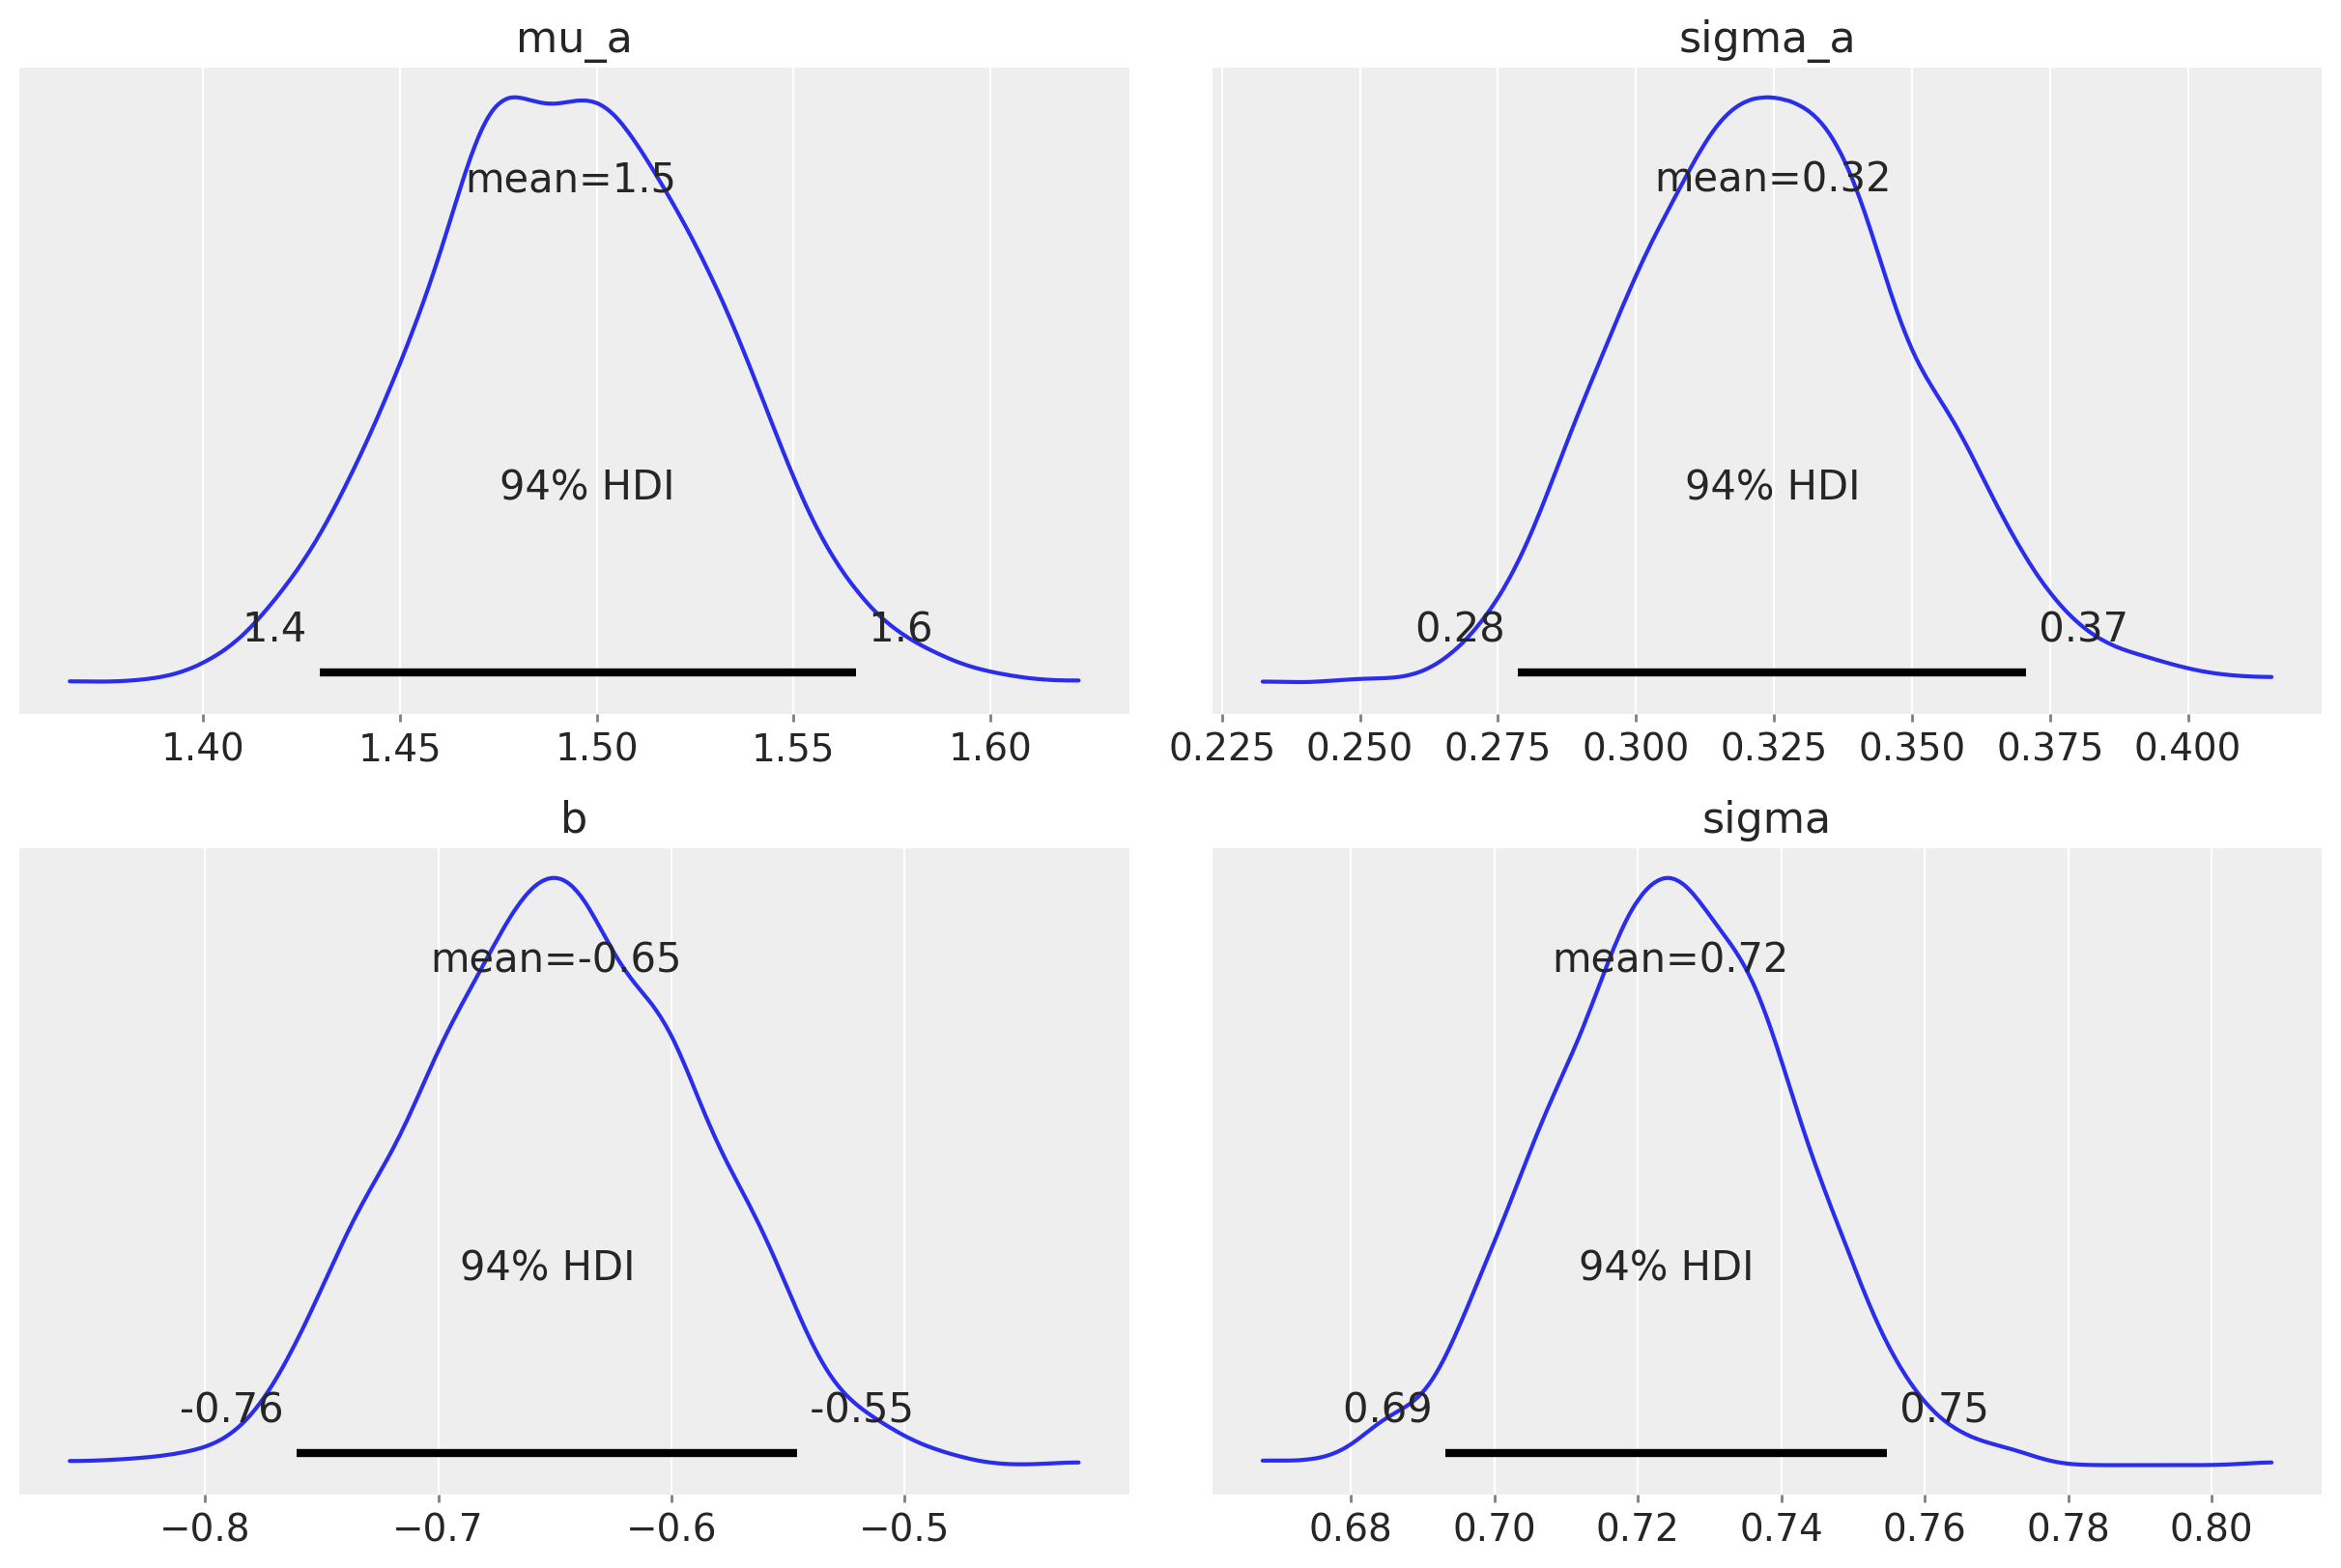

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(12, 8))
az.plot_posterior(varying_intercept_samples, var_names=["mu_a", "sigma_a", "b", "sigma"], ax=ax);

As we suspected, the estimate for the floor coefficient is reliably negative and centered around -0.67. This can be interpreted as houses without basements having about **half** ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county. With this, the estimated average regression line for all the counties can be written as $y = 1.5−0.67x$.

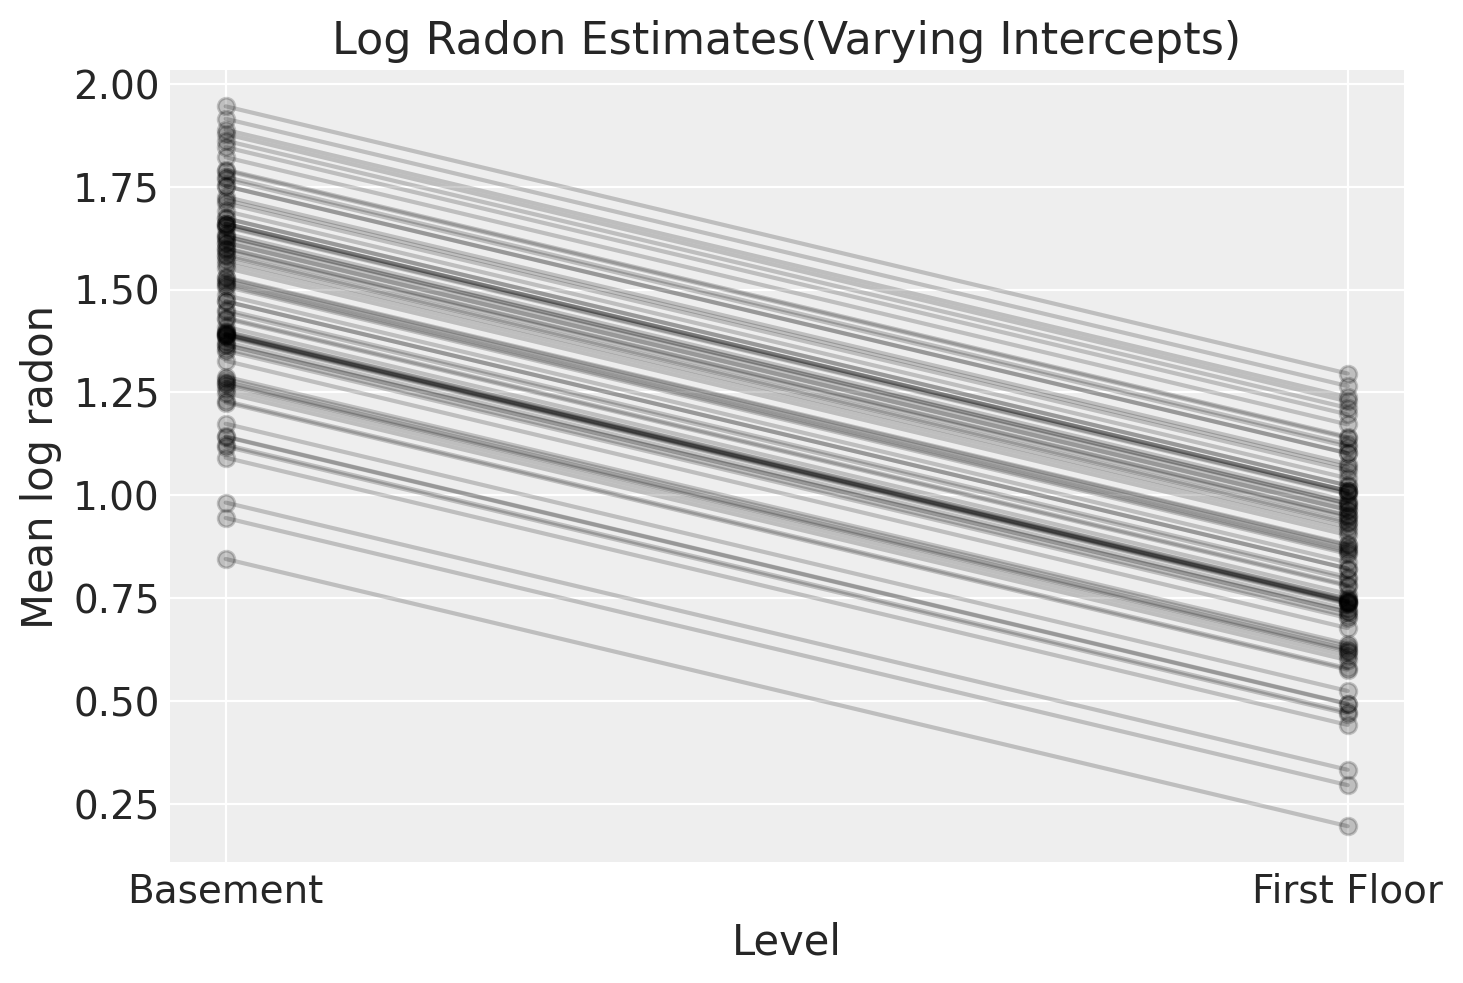

In [ ]:
post = varying_intercept_samples.posterior  # alias for readability
theta = (post.a_county + post.b * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T,"k-", alpha=0.2);  # add lines too
ax.set_title("Log Radon Estimates(Varying Intercepts)");

The graph above shows, for each county, the expected log radon level and the average effect of having no basement.

Let's compare partial pooling estimates with pooled and unpooled models.

<ipython-input-37-0baef2f019b1>:25: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout();


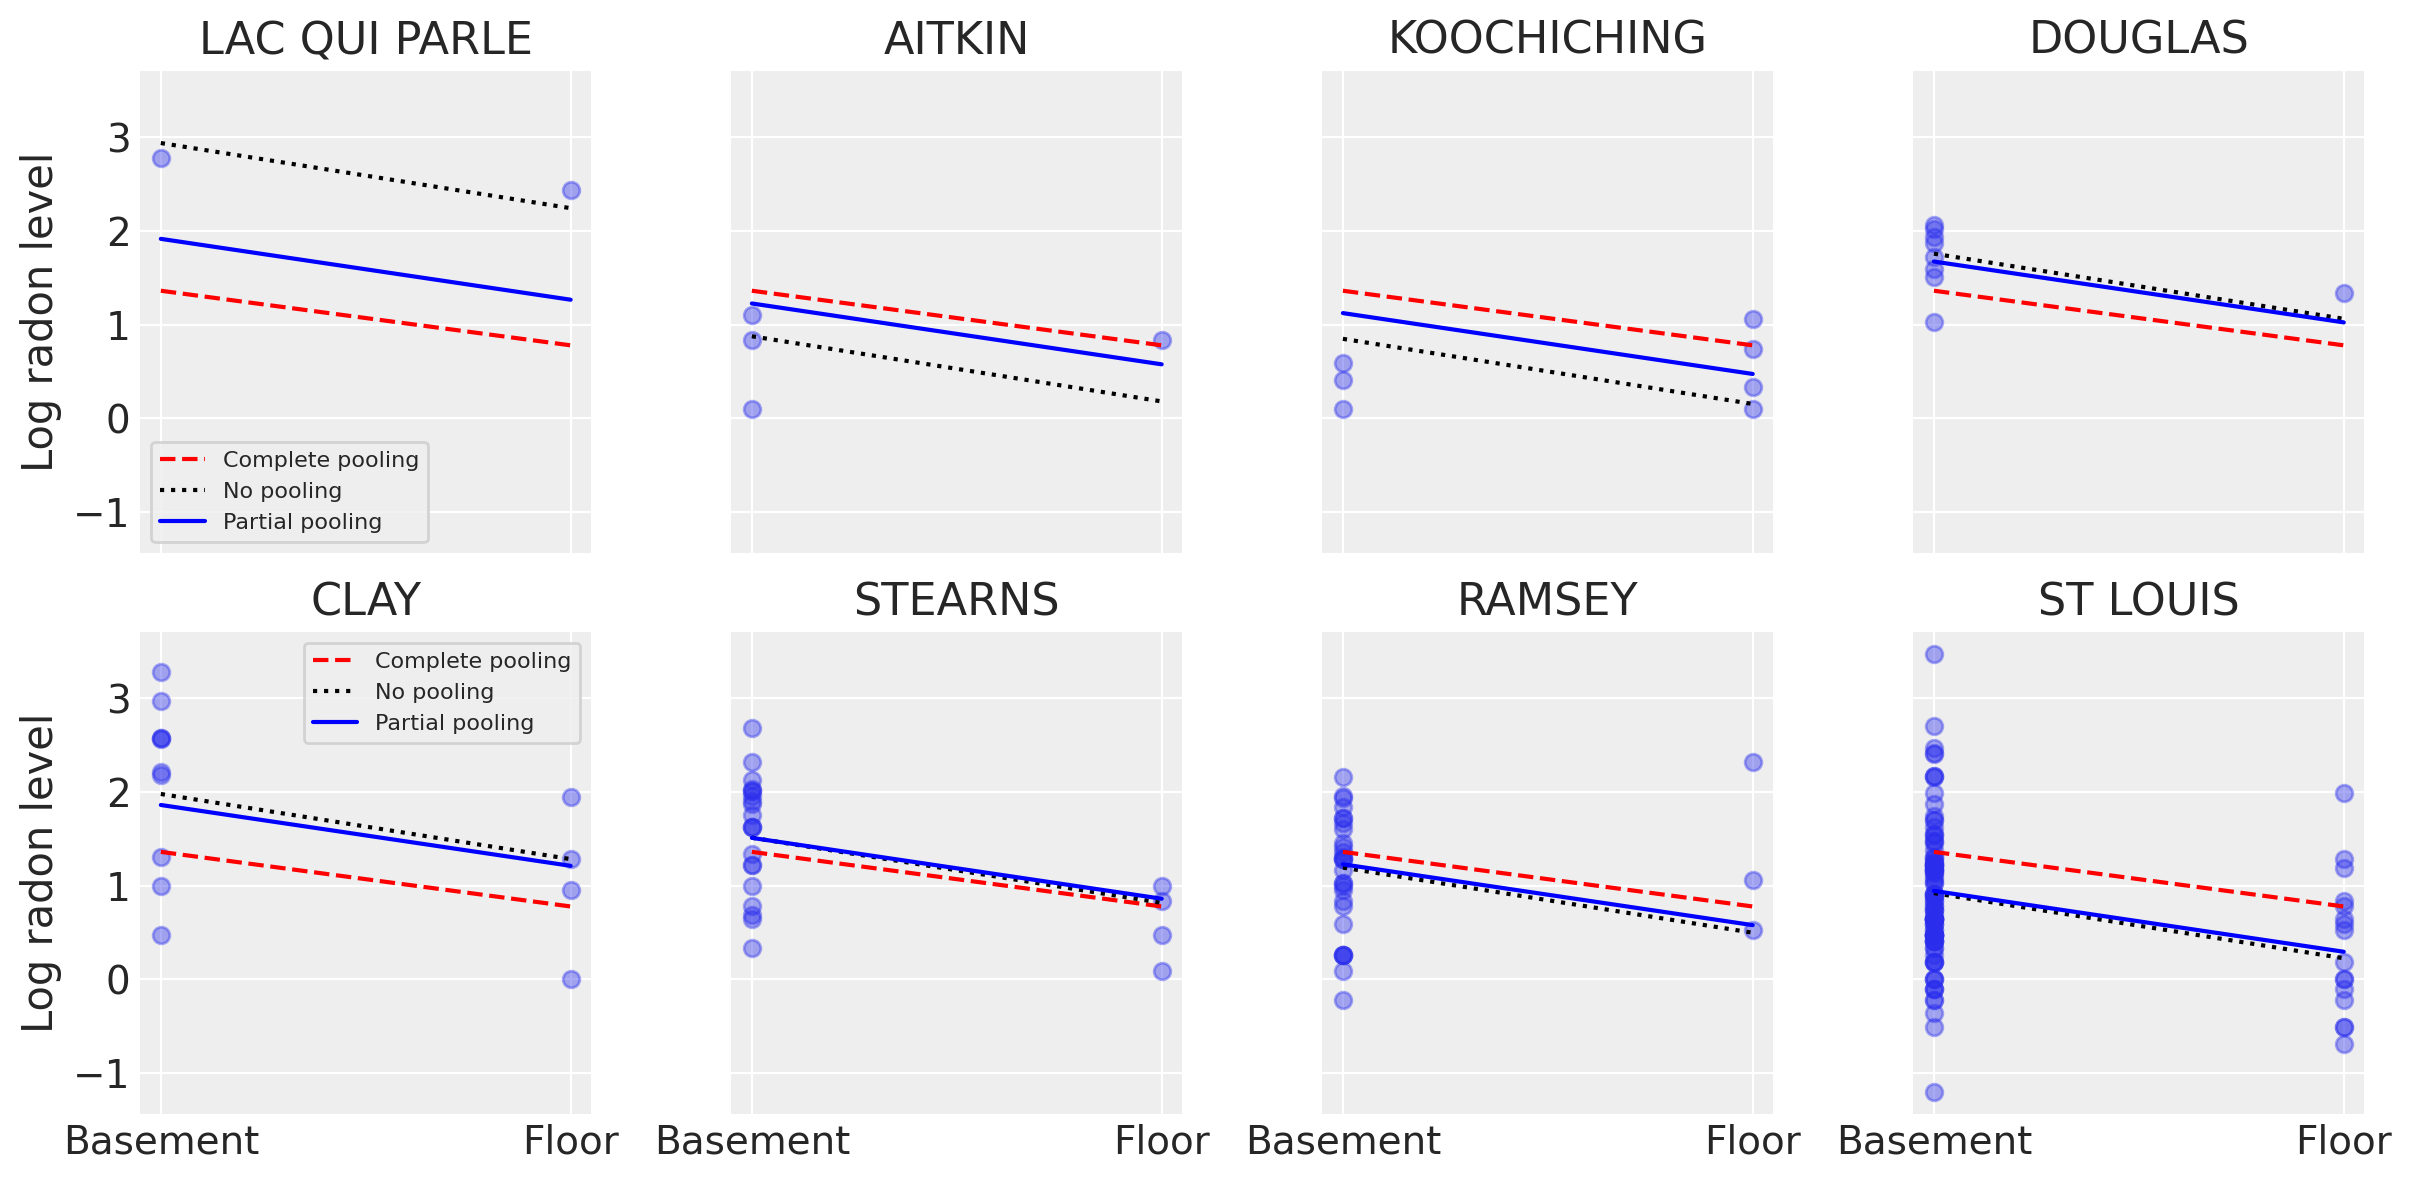

In [ ]:
varying_intercept_samples.observed_data = varying_intercept_samples.observed_data.assign_coords({
    "County": ("obs_id", mn_counties[county_idx]),
    "Level": ("obs_id", np.array(["Basement", "Floor"])[floor.values.astype(np.int32)])
})

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
for ax, c in zip(axes.ravel(), SAMPLE_COUNTIES):
    sample_county_mask = varying_intercept_samples.observed_data.County.isin([c])

    # plot obs:
    unpooled_advi_samples.observed_data.where(
        sample_county_mask, drop=True
    ).sortby("Level").plot.scatter(x="Level", y="y", ax=ax, alpha=.4)

    # plot both models:
    ax.plot([0, 1], pooled_means.a, "r--", label="Complete pooling")
    ax.plot([0, 1], unpooled_means.a_county.sel(a_county_dim_0=c) + unpooled_means.beta*xvals, "k:", label="No pooling")
    ax.plot([0, 1], theta["Mean log radon"].sel(a_county_dim_0=c), "b", label="Partial pooling")

    ax.set_title(c); ax.set_xlabel(""); ax.set_ylabel("")
    

axes[0,0].set_ylabel("Log radon level"); axes[1, 0].set_ylabel("Log radon level")
axes[0,0].legend(fontsize=8, frameon=True), axes[1, 0].legend(fontsize=8, frameon=True)
fig.tight_layout();

Here we clearly see the notion that partial-pooling is a **compromise** between no pooling and complete pooling, as its mean estimates are usually between the other models’ estimates. And interestingly, the bigger (smaller) the sample size in a given county, the closer the partial-pooling estimates are to the no-pooling (complete-pooling) estimates.

#### Varying intercept and slope model
Let's model the effect floor by considering the slope to vary by county as well
$$
y_i = \alpha_{j[i]} + \beta_{j[i]} + \epsilon_i
$$

In [ ]:
@pm.model
def varying_intercept_slope():
    # Hyperpriors
    mu_a = yield pm.Normal('mu_a', loc=0., scale=1.)
    sigma_a = yield pm.HalfCauchy('sigma_a', scale=1.)
    mu_b = yield pm.Normal('mu_b', loc=0., scale=1.)
    sigma_b = yield pm.HalfCauchy('sigma_b', scale=1.)

    # Intercept for each county, distributed around group mean mu_a
    a_county = yield pm.Normal('a_county', loc=mu_a, scale=sigma_a, batch_stack=counties)
    # Slope for each county, distributed around group mean mu_b
    b_county = yield pm.Normal('b_county', loc=mu_b, scale=sigma_b, batch_stack=counties)

    loc = tf.gather(a_county, county_idx) + tf.gather(b_county, county_idx) * data.floor.values
    scale = yield pm.Exponential("sigma", rate=1.)

    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)

In [ ]:
varying_intercept_slope_advi = pm.fit(varying_intercept_slope(), num_steps=25_000)
varying_intercept_slope_samples = varying_intercept_slope_advi.approximation.sample(2_000)
remove_scope(varying_intercept_slope_samples)
varying_intercept_slope_samples

|>>>>>>>>>>>>>>>>>>>>|

Inference data with groups:
	> posterior
	> observed_data

<AxesSubplot:title={'center':'sigma'}>

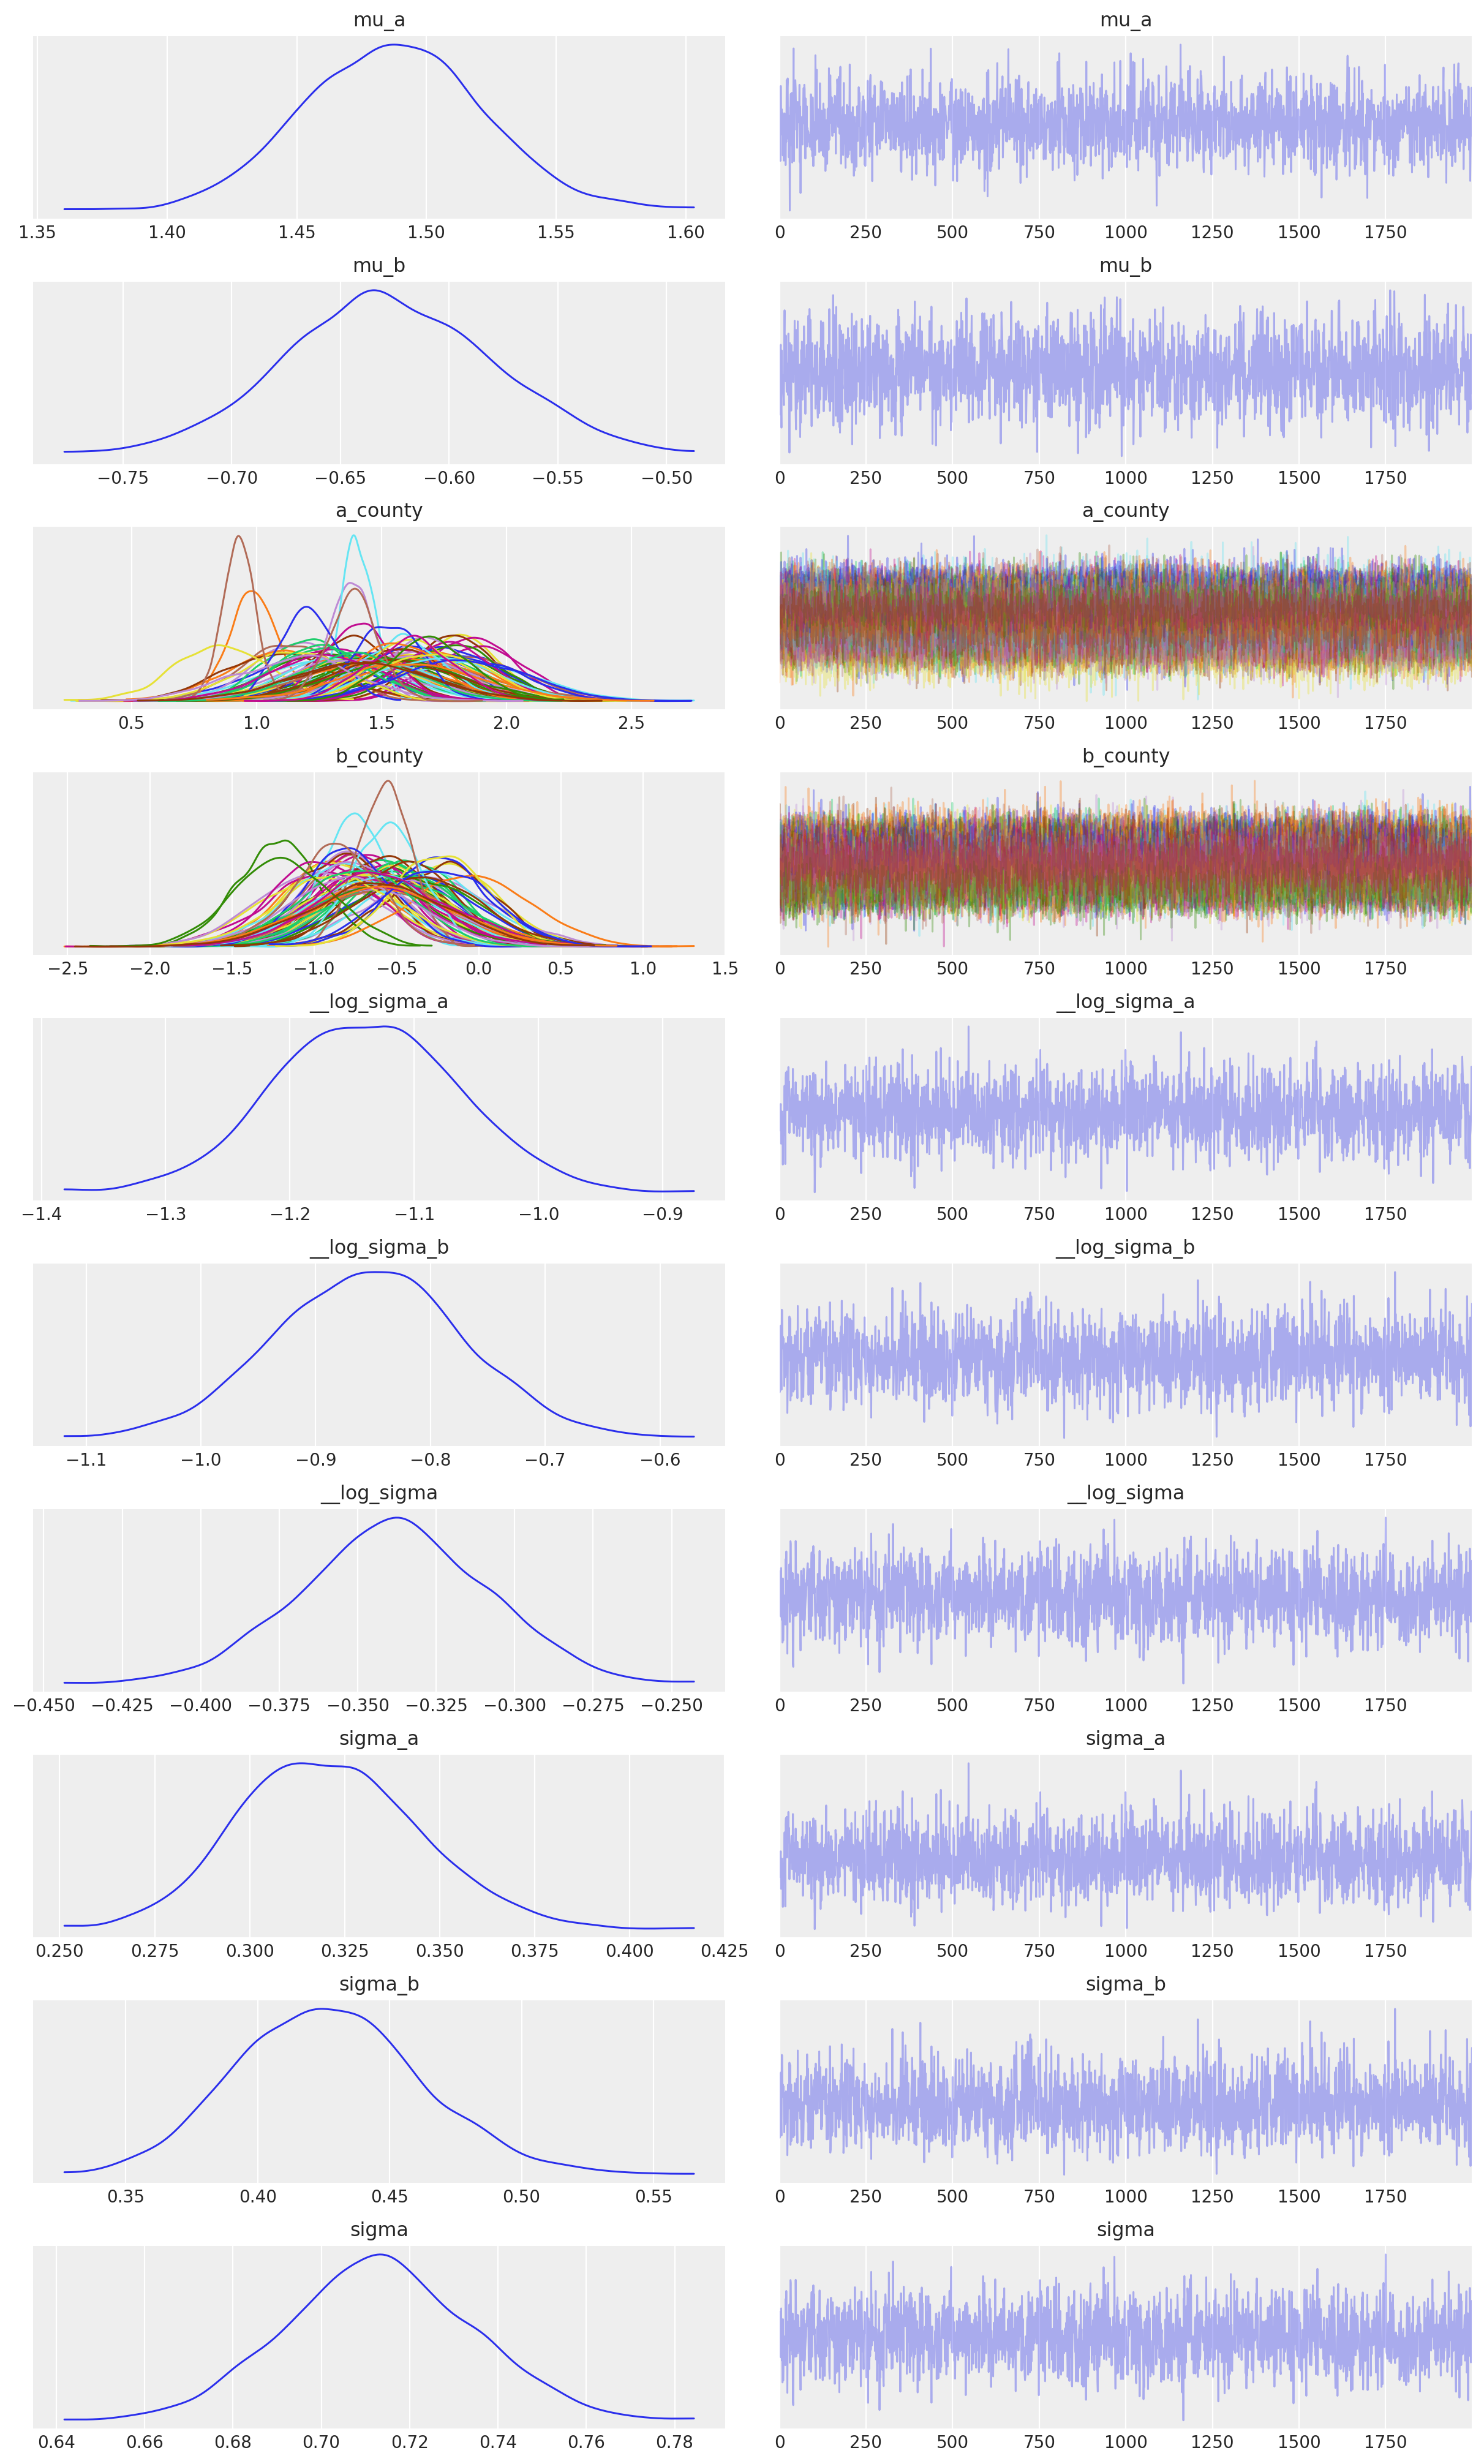

In [ ]:
az.plot_trace(varying_intercept_slope_samples, compact=True)

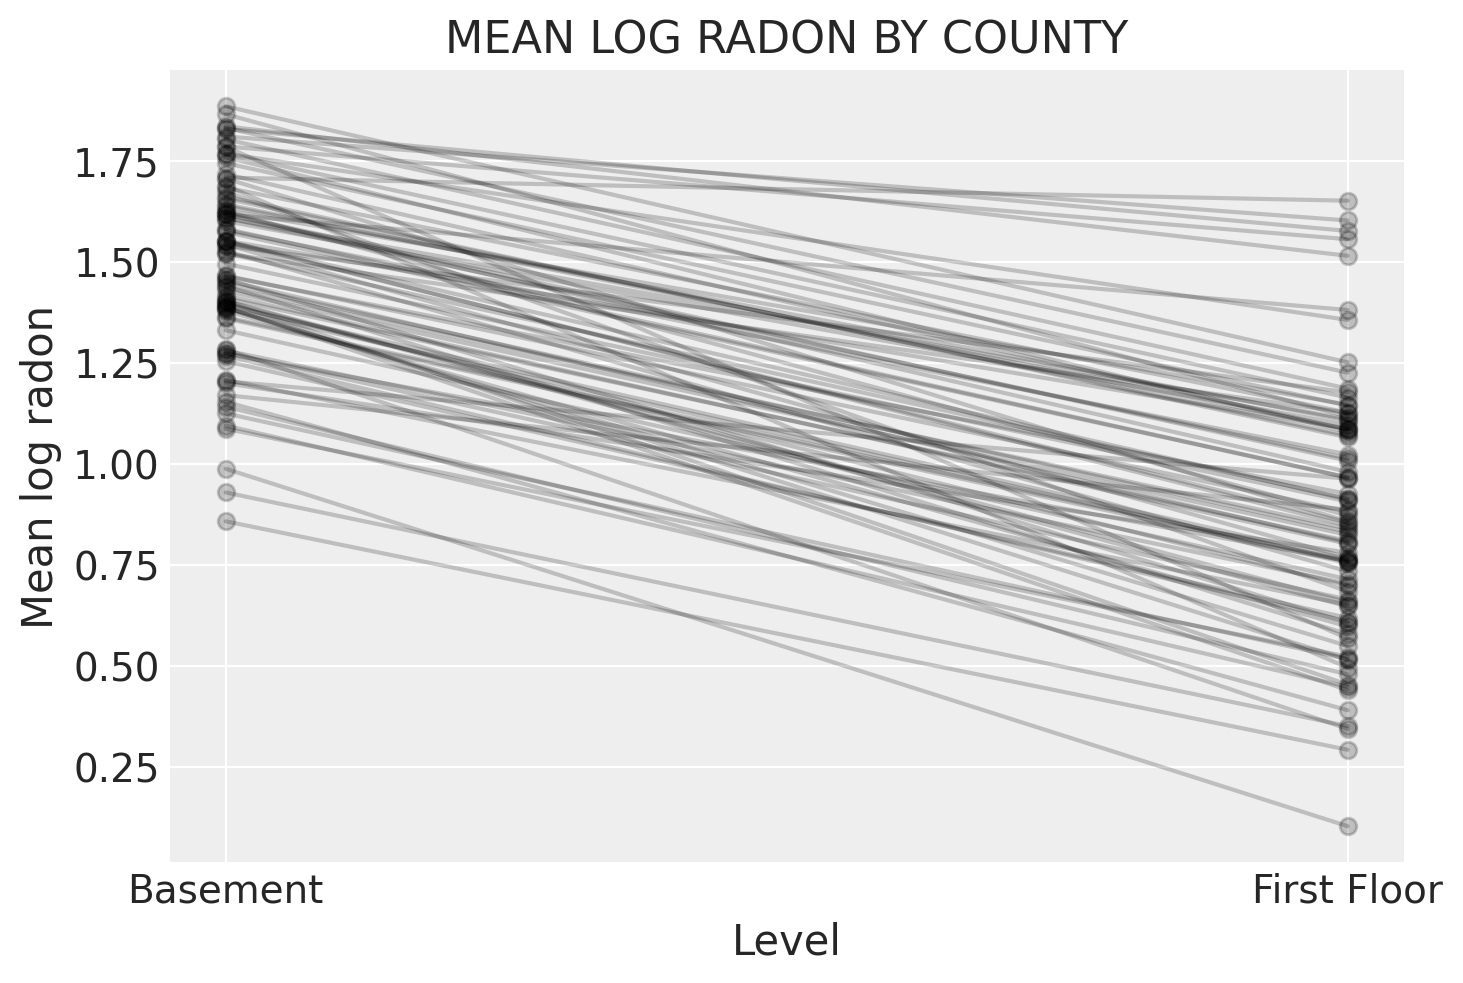

In [ ]:
post = varying_intercept_slope_samples.posterior  # alias for readability
avg_a_county = post.a_county.mean(dim=("chain", "draw"))
avg_b_county = post.b_county.mean(dim=("chain", "draw"))
theta = (avg_a_county.rename(a_county_dim_0="County") + avg_b_county.rename(b_county_dim_0="County")*xvals).to_dataset(name="Mean log radon")

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax) #scatter
ax.plot(xvals, theta["Mean log radon"].T,"k-", alpha=0.2); # add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

We can see that now both the intercept and the slope **vary** by county. Now, the plan of action is to model the covariation between intercepts and slopes using `MvNormal` distribution.

#### Covariation intercept model

$$y \sim Normal(\theta, \sigma)$$

$$\theta = \alpha_{COUNTY} + \beta_{COUNTY} \times floor$$

$$\begin{bmatrix} \alpha_{COUNTY} \\ \beta_{COUNTY} \end{bmatrix} \sim MvNormal(\begin{bmatrix} \alpha \\ \beta \end{bmatrix}, \Sigma)$$

$$\Sigma = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}
     P
     \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}$$


Every correlation matrix can be split into product of its Lower Traingular cholesky factors. 
$$
P = L*L^T
$$
We will make use of `LKJCholesky` distribution from PyMC4 to generate lower triangular cholesky matrix $L$ and then to match its support from unconstrained space, we need to pass a bijector `tfb.CorrelationCholesky` as well. Variational Inference and even MCMC approximations work in **unconstrained** regions.

Read more [here](https://docs.pymc.io/notebooks/LKJ.html) in PyMC3 docs about the use of `LKJ priors` and this [blog post](https://adamhaber.github.io/post/varying-slopes/) by [Adam Haber](https://github.com/adamhaber) to know more about correlation matrices.

In [ ]:
class CorrelationCholesky(pm.distributions.transforms.BackwardTransform):
    name = "cholesky"

    def __init__(self):
        transform = tfb.CorrelationCholesky()
        super().__init__(transform)

In [ ]:
@pm.model
def covariation_intercept_slope():
    sigma_slope = yield pm.Exponential("sigma_slope", rate=tf.cast(1., tf.float64), batch_stack=2)
    cov = yield pm.LKJCholesky('cov', dimension=2, concentration=tf.cast(2, tf.float64), transform=CorrelationCholesky())

    # Hyperpriors
    mu_a = yield pm.Normal('mu_a', loc=tf.cast(0., tf.float64), scale=tf.cast(5., tf.float64))
    mu_b = yield pm.Normal('mu_b', loc=tf.cast(0., tf.float64), scale=tf.cast(5., tf.float64))
    ab_county = yield pm.MvNormalCholesky(
        'ab_county', tf.stack([mu_a, mu_b]), tf.linalg.LinearOperatorDiag(sigma_slope).matmul(cov), batch_stack=counties
        )

    loc = tf.gather(ab_county[:, 0], county_idx) + tf.gather(ab_county[:, 1], county_idx)*floor
    scale = yield pm.Exponential("sigma", rate=tf.cast(1., tf.float64))
    y = yield pm.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)


Let's also use higher `sample_size` to achieve better convergence.

In [ ]:
covariation_intercept_slope_advi = pm.fit(covariation_intercept_slope(), num_steps=25_000, sample_size=10)

|>>>>>>>>>>>>>>>>>>>>|

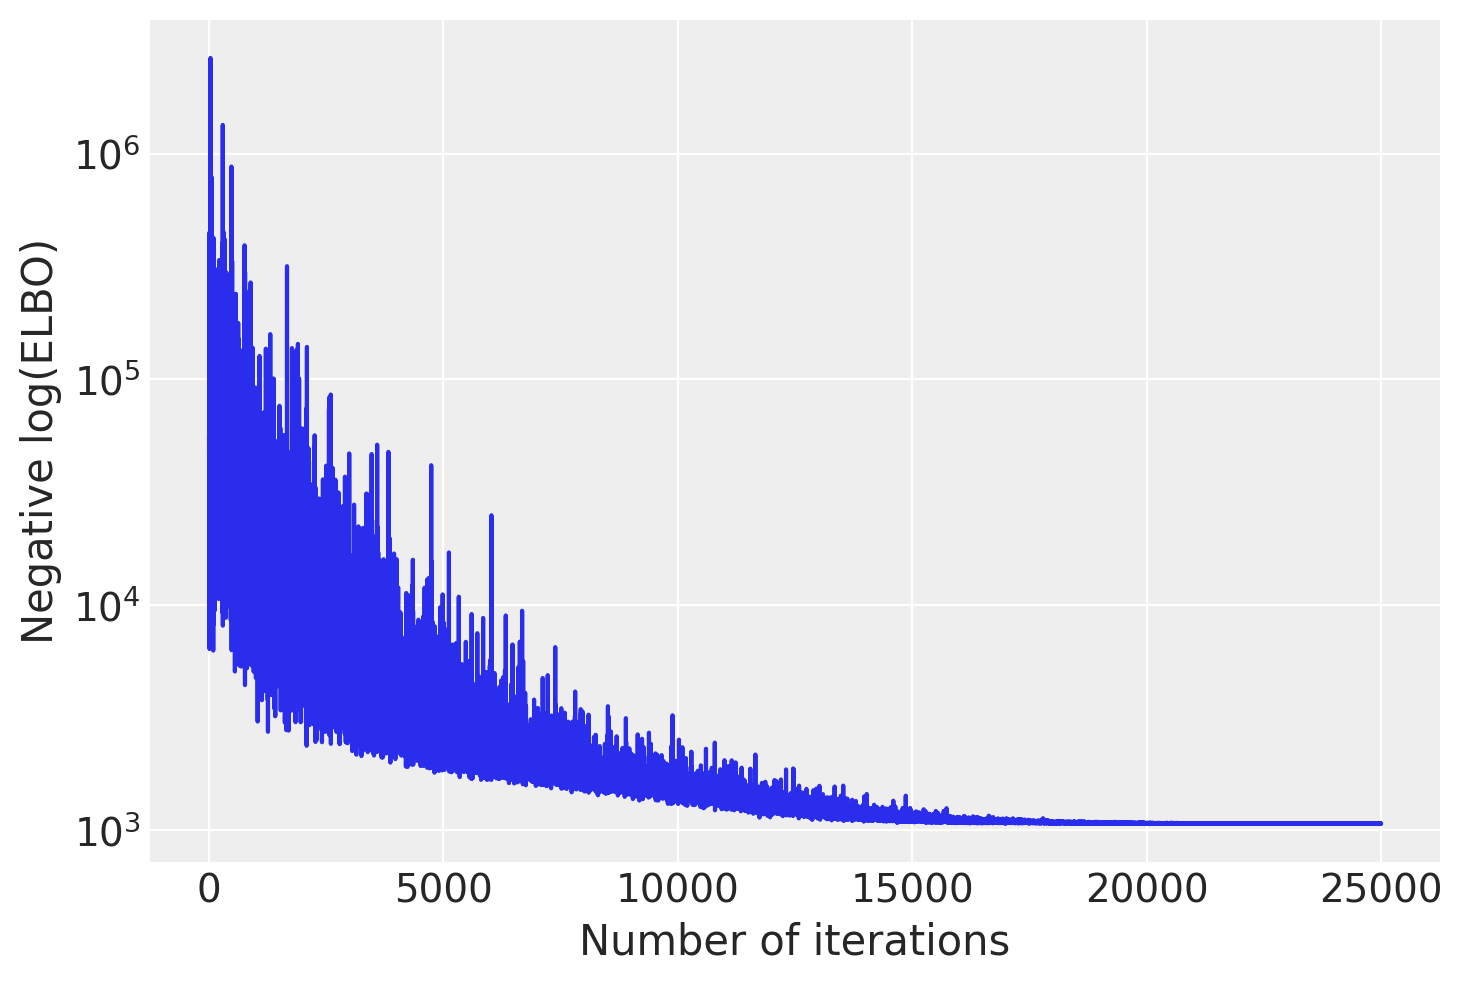

In [ ]:
plot_elbo(covariation_intercept_slope_advi.losses)



Since, the variable `cov` is a lower triangular matrix, we need to multiply it with its transpose to get back the correlation matrix.

In [ ]:
covariation_intercept_slope_samples = covariation_intercept_slope_advi.approximation.sample(3_000)
remove_scope(covariation_intercept_slope_samples)
covariation_intercept_slope_samples.posterior["cov"].values = np.matmul(
    covariation_intercept_slope_samples.posterior["cov"].values,
    np.transpose(covariation_intercept_slope_samples.posterior["cov"].values, (0, 1, 3, 2))
)
covariation_intercept_slope_samples

Inference data with groups:
	> posterior
	> observed_data

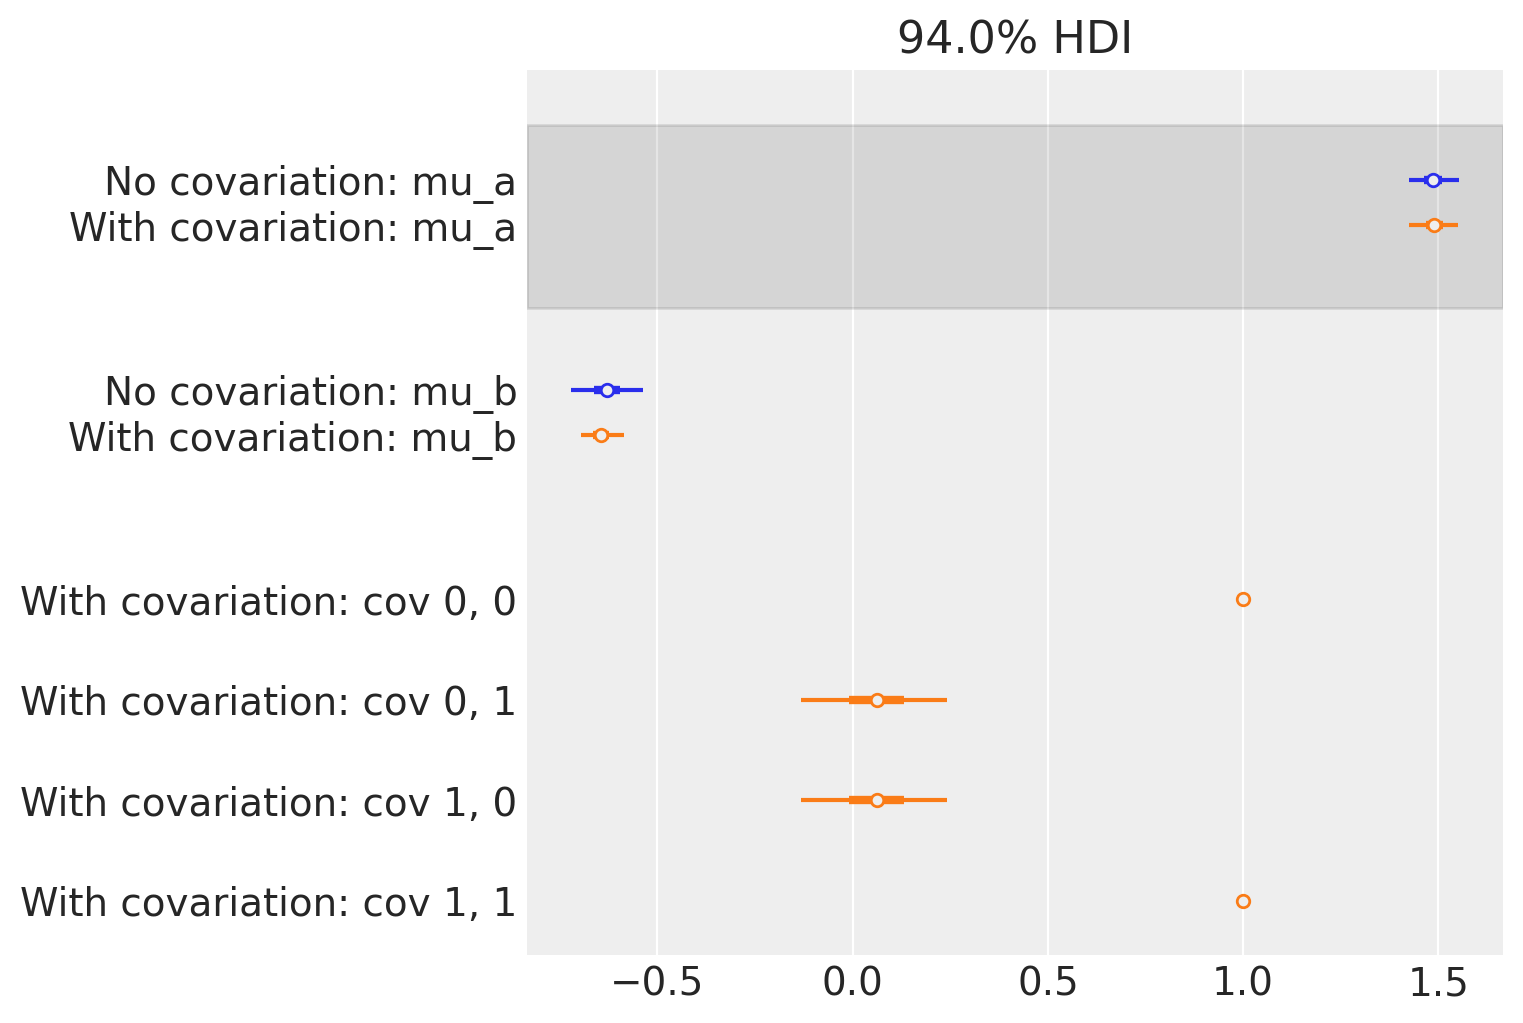

In [ ]:
az.plot_forest(
    [varying_intercept_slope_samples, covariation_intercept_slope_samples],
    model_names=["No covariation", "With covariation"],
    var_names=["mu_a", "mu_b", "cov"],
    combined=True,
    figsize=(7.5, 5),
);

In [ ]:
covariation_intercept_slope_samples.posterior["cov"].mean(dim=["chain", "draw"]).values

array([[1.        , 0.06146909],
       [0.06146909, 1.        ]])

Observing from the forest plot and the mean values, the correlation matrix is close to the **Identity matrix**. So, it is not a good idea to model the correlation using Mean Field ADVI as it fits the model with Diagonal Gaussian distribution. In general, any VI approximation does not care about hierarchies in the model. All it considers is to optimizer ELBO in an unbounded space. 

We have FullRank ADVI as a rescue that poses dense covariance matrix over all the parameters but it requires more memory and computational resources. Let's figure out if FullRank ADVI can capture some correlations.

|>>>>>>>>>>>>>>>>>>>>|

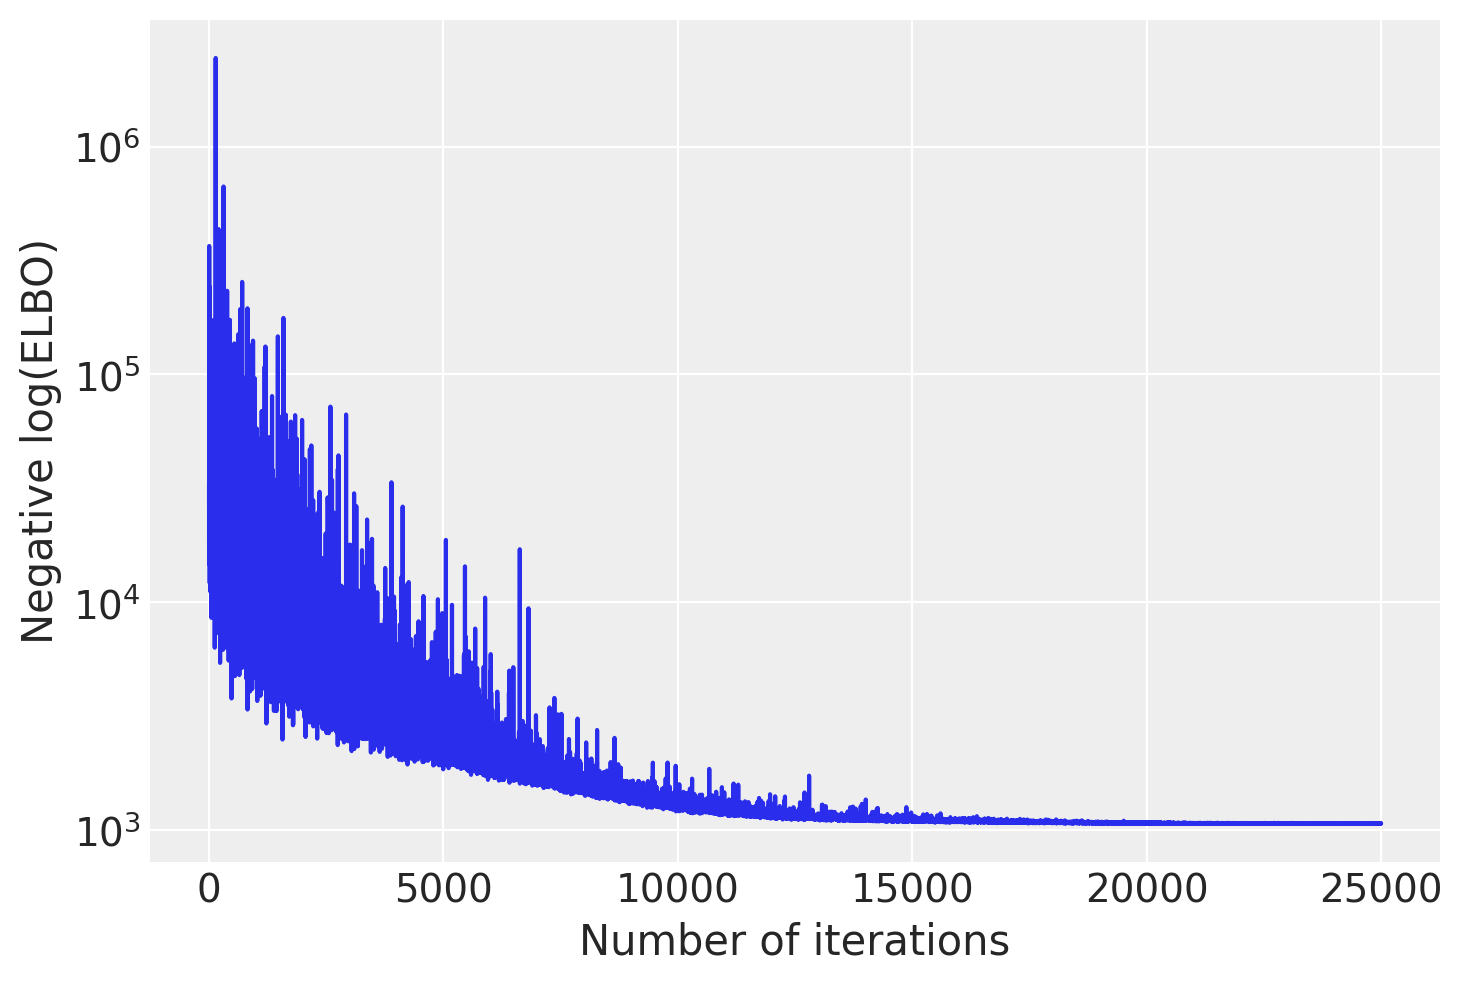

In [ ]:
covariation_intercept_full_rank = pm.fit(covariation_intercept_slope(), sample_size=10,
                                         num_steps=25_000, method="fullrank_advi")
plot_elbo(covariation_intercept_full_rank.losses)

In [ ]:
covariation_intercept_full_rank_samples = covariation_intercept_full_rank.approximation.sample(4_000)
remove_scope(covariation_intercept_full_rank_samples)
covariation_intercept_full_rank_samples.posterior["cov"].values = np.matmul(
    covariation_intercept_full_rank_samples.posterior["cov"].values,
    np.transpose(covariation_intercept_full_rank_samples.posterior["cov"].values, (0, 1, 3, 2))
)
covariation_intercept_full_rank_samples

Inference data with groups:
	> posterior
	> observed_data

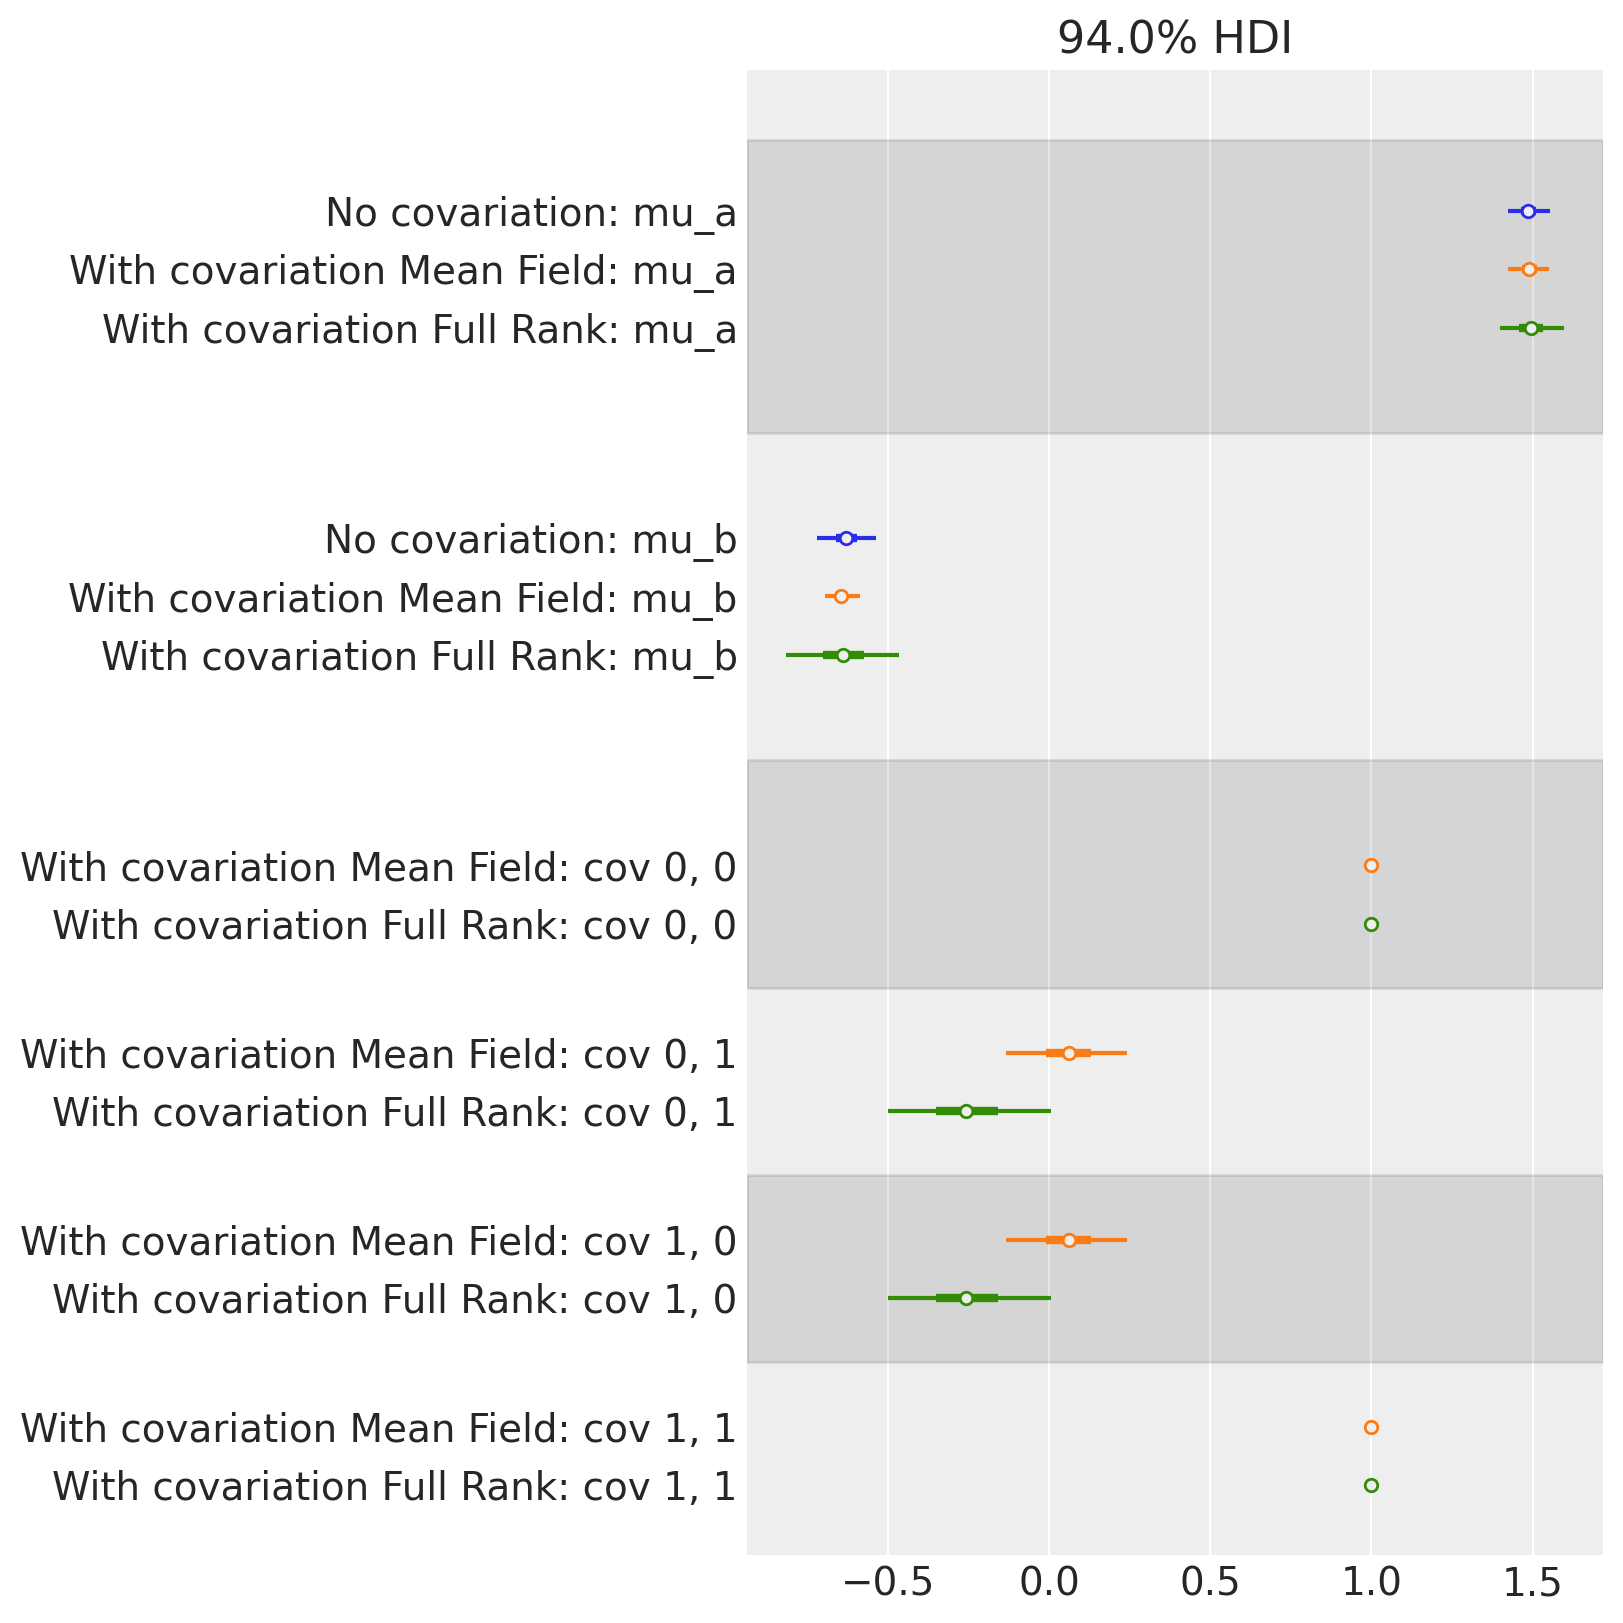

In [ ]:
az.plot_forest(
    [varying_intercept_slope_samples, covariation_intercept_slope_samples, covariation_intercept_full_rank_samples],
    model_names=["No covariation", "With covariation Mean Field", "With covariation Full Rank"],
    var_names=["mu_a", "mu_b", "cov"],
    combined=True,
    figsize=(8, 8),
);

So the correlation between slopes and intercepts seems to be negative: when a_county increases, b_county tends to decrease. Also the estimates are close for both `mu` and `sigma` when using `fullrank_advi`. MeanField and FullRank ADVI are extreme ends of computing correlations. But now, PyMC4 comes with a LowRank ADVI approximation to let us decide how much correlation we wish to see. 

In [ ]:
covariation_intercept_slope_advi.approximation.order.size

176

The flattened shape of all parameters in our model is 176. So, we can specify a `rank` anyway between 1 and 176. Closer to zero, represents MeanField behaviour and closer to 176, resembles FullRank behaviour.

|>>>>>>>>>>>>>>>>>>>>|

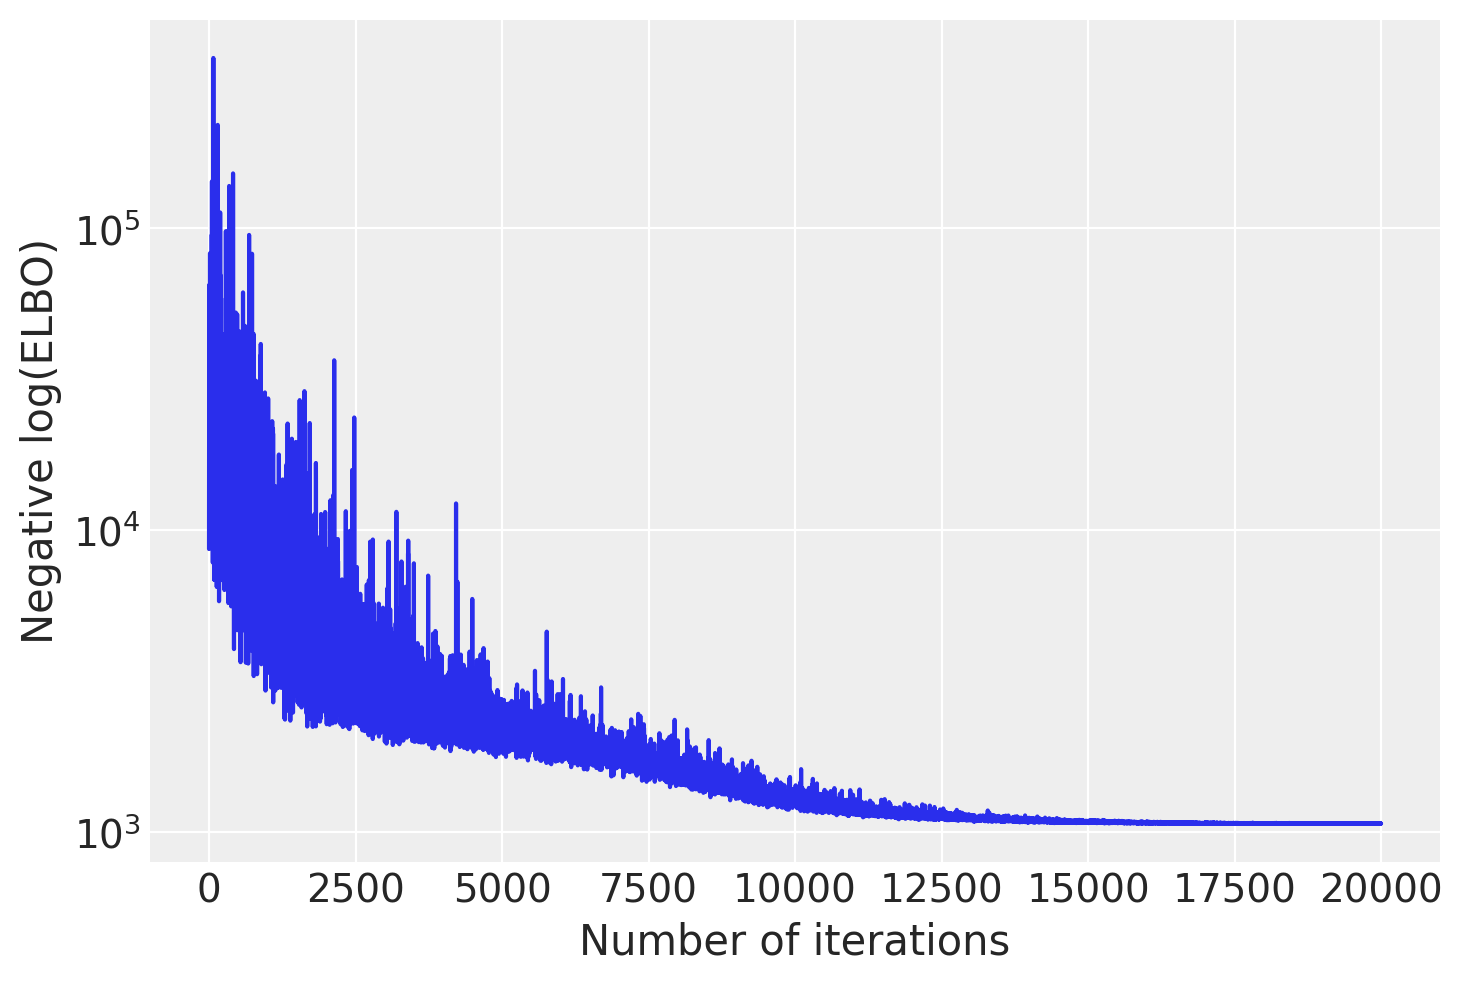

In [ ]:
covariation_intercept_low_rank = pm.fit(covariation_intercept_slope(), num_steps=20_000, method="lowrank_advi", 
                                        sample_size=10, approx_kwargs=dict(rank=50))
plot_elbo(covariation_intercept_low_rank.losses)

In [ ]:
covariation_intercept_low_rank_samples = covariation_intercept_low_rank.approximation.sample(4_000)
remove_scope(covariation_intercept_low_rank_samples)
covariation_intercept_low_rank_samples.posterior["cov"].values = np.matmul(
    covariation_intercept_low_rank_samples.posterior["cov"].values, 
    np.transpose(covariation_intercept_low_rank_samples.posterior["cov"].values, (0, 1, 3, 2))
)
covariation_intercept_low_rank_samples

Inference data with groups:
	> posterior
	> observed_data

In [ ]:
covariation_intercept_low_rank_150 = pm.fit(covariation_intercept_slope(), num_steps=20_000, method="lowrank_advi", 
                                        sample_size=10, approx_kwargs=dict(rank=150))

|>>>>>>>>>>>>>>>>>>>>|

In [ ]:
covariation_intercept_low_rank_150_samples = covariation_intercept_low_rank_150.approximation.sample(4_000)
remove_scope(covariation_intercept_low_rank_150_samples)
covariation_intercept_low_rank_150_samples.posterior["cov"].values = np.matmul(
    covariation_intercept_low_rank_150_samples.posterior["cov"].values, 
    np.transpose(covariation_intercept_low_rank_150_samples.posterior["cov"].values, (0, 1, 3, 2))
)
covariation_intercept_low_rank_150_samples

Inference data with groups:
	> posterior
	> observed_data

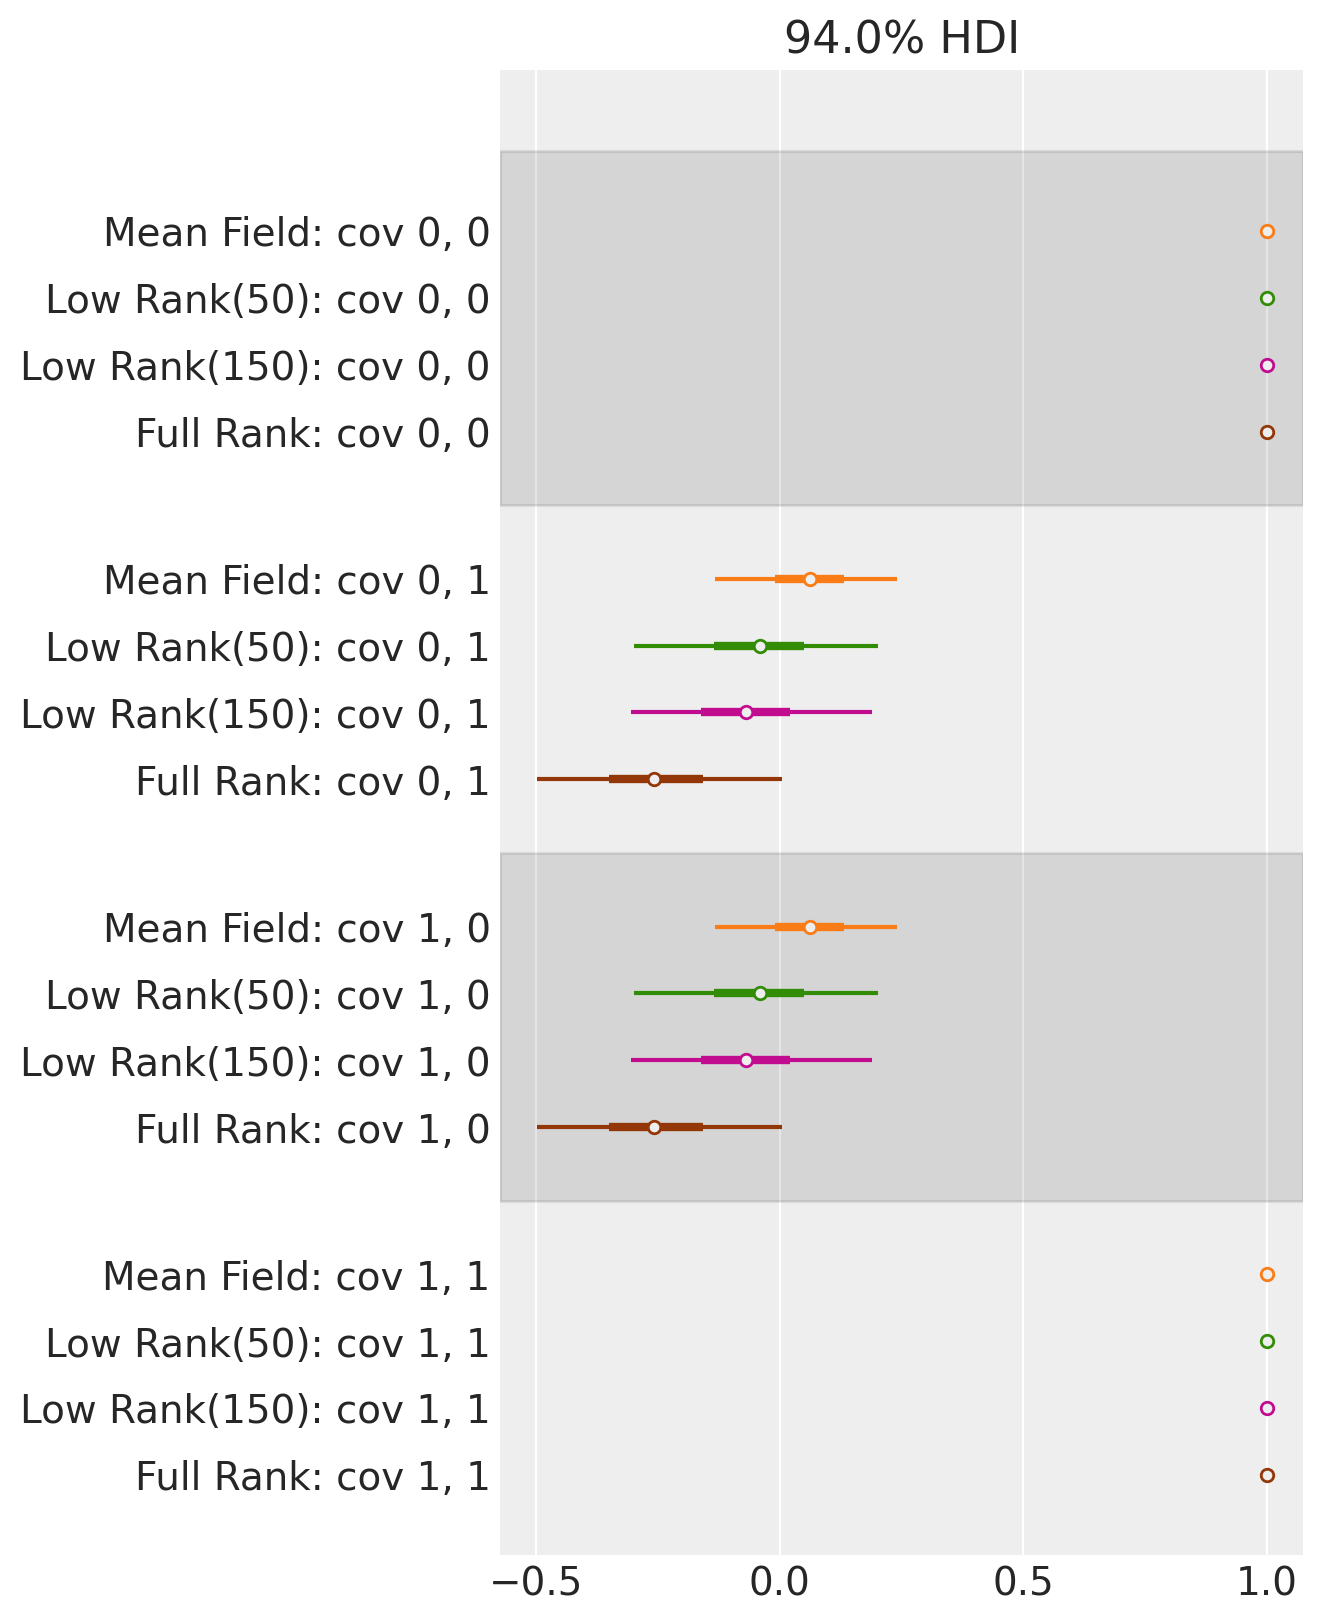

In [ ]:
az.plot_forest(
    [
        varying_intercept_slope_samples,
        covariation_intercept_slope_samples,
        covariation_intercept_low_rank_samples,
        covariation_intercept_low_rank_150_samples,
        covariation_intercept_full_rank_samples
    ],
    model_names=["No covariation", "Mean Field", "Low Rank(50)", "Low Rank(150)", "Full Rank"],
    var_names=["cov"],
    combined=True,
    figsize=(6.5, 8),
);

We can see a **negative** coorelation as the mean of correlation matrix lies around -0.25. This means when the intercept increases, the slope decreases. Interestingly, by increasing the rank for LowRank ADVI, the correlation is getting close to that in case of FullRank ADVI one.

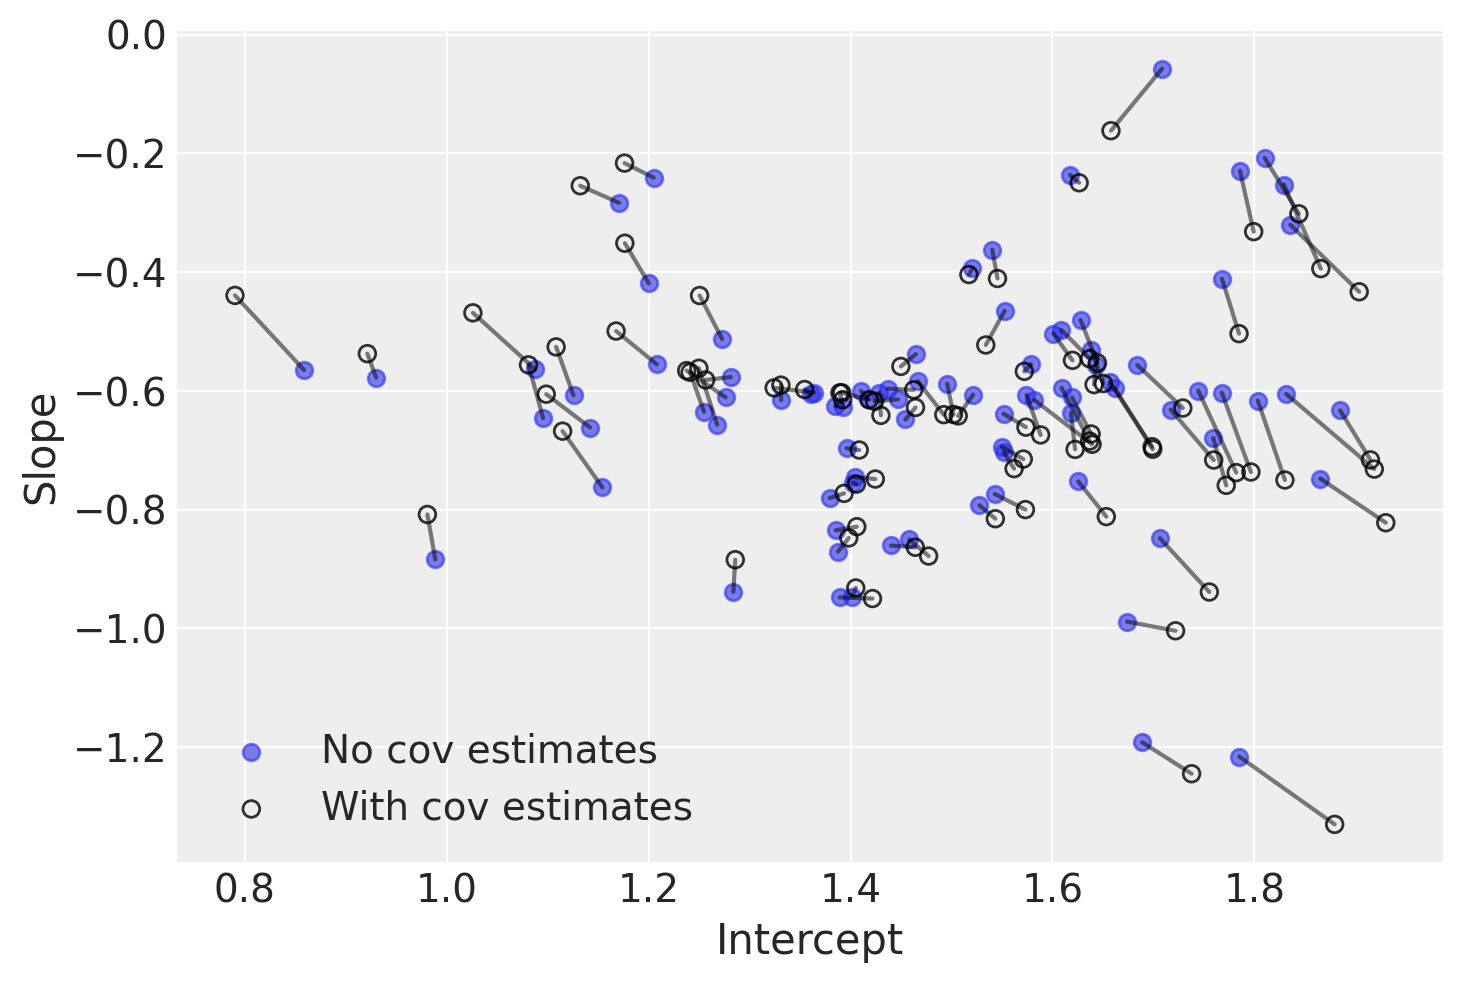

In [ ]:
a_county_cov = covariation_intercept_full_rank_samples.posterior["ab_county"].mean(dim=("chain", "draw"))[:, 0]
b_county_cov = covariation_intercept_full_rank_samples.posterior["ab_county"].mean(dim=("chain", "draw"))[:, 1]

# plot both and connect with lines
plt.scatter(avg_a_county, avg_b_county, label="No cov estimates", alpha=0.6)
plt.scatter(
    a_county_cov,
    b_county_cov,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="With cov estimates",
    alpha=0.8,
)
plt.plot([avg_a_county, a_county_cov], [avg_b_county, b_county_cov], "k-", alpha=0.5)
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

Interestingly, the differences between both models occur at extreme slope and intercept values. This is because the second model used the slightly negative correlation between intercepts and slopes to adjust their estimates and brings out more information from the data.

* Mean Field tends to scale better to larger datasets where correlation between parameters is not much concerned.
* Fitting data with FullRank can capture very good correlations on par with MCMC but comes with its own computational problems.
* LowRank ADVI can be seen as a mid-way of both extremes.

##### TODO
Perform waic and loo tests to compare models. I need to learn about this.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas     1.1.1
arviz      0.9.0
tensorflow 2.4.0-dev20200905
pymc4      4.0a2
logging    0.5.1.2
xarray     0.16.0
numpy      1.18.5
last updated: Sun Sep 06 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
